In [1]:
import numpy as np
import matplotlib.pyplot as plt
import importlib as imp
import osyris
from numba import njit, prange, stencil
import matplotlib.colors as colors

import disctools
import disctools.disc_cuts
import disctools.datacube
import disctools.contour_integrals
import disctools.datacube_utils
import disctools.disc_analysis
import disctools.intersections
import disctools.constants as constants

convert=constants.conversions()

%matplotlib notebook

In [2]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

In [3]:
@njit
def cut_mom_in(momentum):
    absmom=np.abs(momentum[:,:,:,2])
    return absmom>0.005*np.max(absmom)

In [4]:
@njit(parallel=True)
def broadcast_dot(vector_array,scalar_array):
    nx,ny,nz,_=vector_array.shape
    return_array=np.zeros_like(vector_array)
    for i in prange(nx):
        for j in range(ny):
            for k in range(nz):
                return_array[i,j,k,0]=vector_array[i,j,k,0]*scalar_array[i,j,k]
                return_array[i,j,k,1]=vector_array[i,j,k,1]*scalar_array[i,j,k]
                return_array[i,j,k,2]=vector_array[i,j,k,2]*scalar_array[i,j,k]
    return return_array

In [5]:
@njit
def get_a_on_grid_2D(star_mass,positions,velocities,dens):
    nx,ny,discard=velocities.shape
    a=np.zeros_like(dens)
    for i in prange(nx):
        for j in range(ny):
            a[i,j]=disctools.disc_analysis.get_a(star_mass,positions[i,j],velocities[i,j,:])
    return a

In [6]:
@njit
def toomre_Q(pressure,surfaceDensity):
    G=6.6743E-8
    return pressure*1.5/(np.pi*G*surfaceDensity)

@njit
def toomre_Q_array(midplanePressure,surfaceDensity):
    Q=np.zeros_like(surfaceDensity)
    nx,ny=midplanePressure.shape
    for i in prange(nx):
        for j in range(ny):
            Q[i,j]=toomre_Q(midplanePressure[i,j],surfaceDensity[i,j])
    return Q

In [ ]:
output_number=-1

Processing 128 files in ./output_01616
 10% : read     171136 cells,         17 particles
 20% : read     486595 cells,        127 particles
 30% : read     679371 cells,        292 particles
 40% : read     742280 cells,        343 particles
 50% : read     796120 cells,       2147 particles
 60% : read     873537 cells,       2155 particles
 70% : read     946010 cells,      11560 particles
 80% : read    1004717 cells,      12491 particles
 90% : read    1856884 cells,      13018 particles
Loaded: 3095240 cells, 13309 particles.
(246, 246, 246, 3)
building amr level 13
building amr level 14
building amr level 15
building amr level 16


<IPython.core.display.Javascript object>


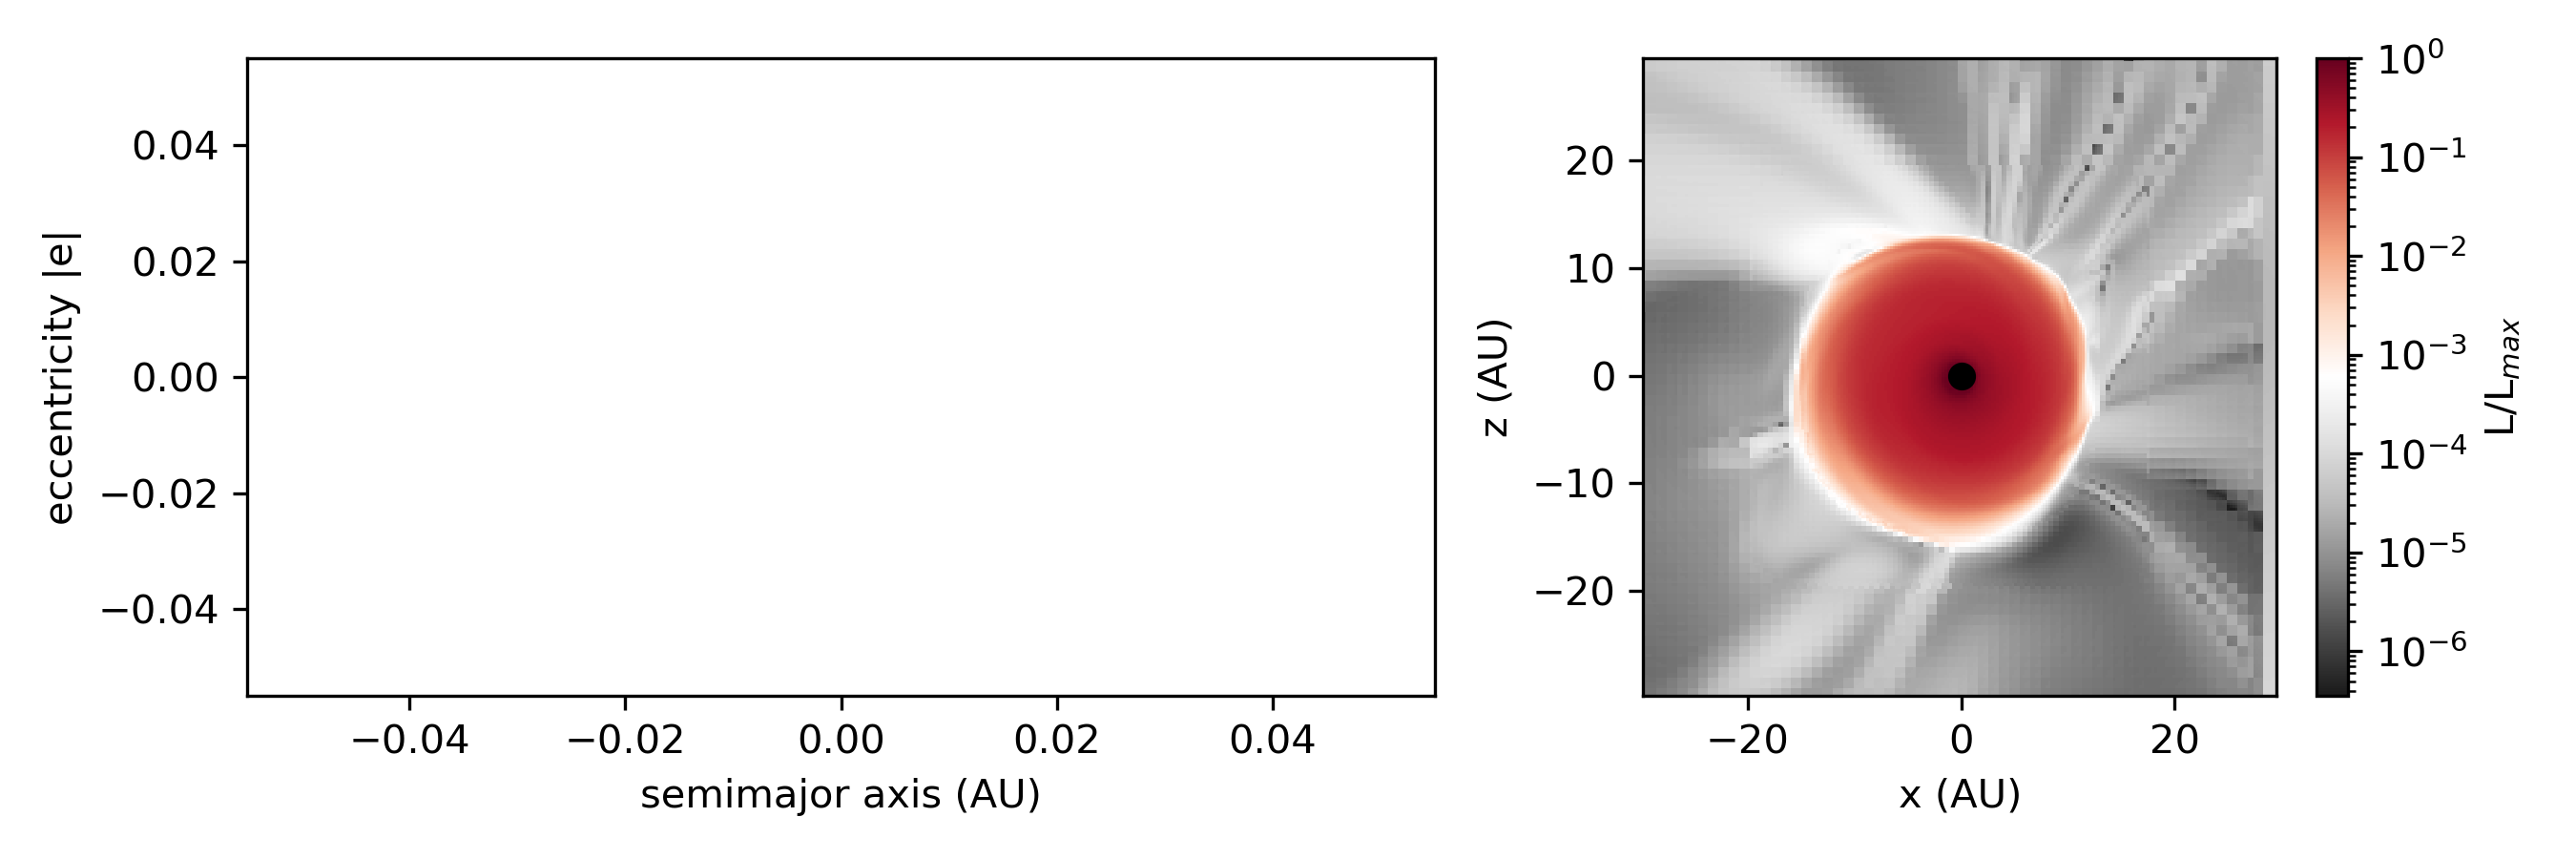

In [7]:
data = osyris.Dataset(output_number, path=".").load()
box_l_x,box_l_y,box_l_z=60,60,60
data=osyris.extract_box(data,dx=box_l_x*osyris.units("au"), dy=box_l_y*osyris.units("au"), dz=box_l_z*osyris.units("au"), origin=data["sink"]["position"])
data["amr"]["position"]=data["amr"]["position"]-data["sink"]["position"]
imp.reload(disctools.datacube)

dx=(np.min(data["amr"]["dx"].values),np.min(data["amr"]["dx"].values),np.min(data["amr"]["dx"].values))
l=(box_l_x*convert.au_to_cm,box_l_y*convert.au_to_cm,box_l_z*convert.au_to_cm)
s=(-0.5*box_l_x*convert.au_to_cm,-0.5*box_l_y*convert.au_to_cm,-0.5*box_l_z*convert.au_to_cm)
cube=disctools.datacube.make_cube(dx,l,s)
print(cube.shape)

positionArray=np.stack((data["amr"]["position"].x.values,data["amr"]["position"].y.values,data["amr"]["position"].z.values),axis=-1)
imap=disctools.datacube.make_amr_mapping(positionArray,cube,data["amr"]["level"].values)
density=disctools.datacube.fill_array_scalar(data["hydro"]["density"].values,imap)
velocity=disctools.datacube.fill_array_vector(data["hydro"]["velocity"].x.values,data["hydro"]["velocity"].y.values,data["hydro"]["velocity"].z.values,imap)
angularMom=disctools.disc_analysis.angular_momentum(velocity,density,1.0,cube)
totmom=disctools.disc_analysis.angular_momentum_sphere(velocity,density,1.0,cube)

cm_to_au = 6.6845871226706E-14
cube_au=cube*cm_to_au

sink_pos=np.array((0.0,0.0,0.0))
sink_pos.reshape(1,3)
cut_Dens=disctools.disc_cuts.make_cut_array(density,cut_mom_in,angularMom)
cut_density=disctools.disc_cuts.make_cut_array(density,cut_mom_in,angularMom)
cut_velocity=disctools.disc_cuts.make_cut_array(velocity,cut_mom_in,angularMom)
cut_cube=disctools.disc_cuts.make_cut_array(cube,cut_mom_in,angularMom)


radii=np.linspace(1.0,12,60)
e_list=[]
a_grid=disctools.disc_analysis.get_a_on_grid(0.264*1.989E33,cube,velocity,density)*convert.cm_to_au
for a in radii:
    averaged_densities=np.zeros(16)
    #a_mask=disctools.disc_analysis.in_bin(a_grid,disctools.disc_analysis.bin((a-0.2,a+0.2)))
    a_mask=np.where(np.abs(a_grid-a)<0.1,True,False)
    e=disctools.disc_analysis.mean_eccentricity(0.264*1.989E33,cut_cube[a_mask],cut_velocity[a_mask],cut_density[a_mask])
    e_list.append(e)
el=np.array([np.linalg.norm(e) for e in e_list])
 
peak=np.unravel_index(np.argmax(density),density.shape)
    
fig, (ecc_plot,map_plot) = plt.subplots(1,2,figsize=(9,3),gridspec_kw={'width_ratios': [1.5, 1]})
#ecc_plot.set_figheight(10)
#map_plot.set_aspect(1)
c = map_plot.pcolormesh(cube_au[1:-1,1:-1,peak[2],0], cube_au[1:-1,1:-1,peak[2],1], np.linalg.norm(angularMom[1:-1,1:-1,peak[2],:],axis=-1)/np.max(np.linalg.norm(angularMom[1:-1,1:-1,peak[2],:],axis=-1)),norm=colors.LogNorm(), cmap='RdGy_r')
cbar=fig.colorbar(c, ax=map_plot).set_label("L/L$_{max}$")
sink_position_point=map_plot.scatter([0.0],[0.0],color="black")
#cont = map_plot.contour(cube_au[5:-5,5:-5,81,0], cube_au[5:-5,5:-5,81,1], np.linalg.norm(angularMom[5:-5,5:-5,81,:],axis=-1)/np.max(np.linalg.norm(angularMom[:,:,81,:])), [0.0001],cmap="magma")

map_plot.set_xlabel("x (AU)")
map_plot.set_ylabel("z (AU)")

ecc_plot.plot(radii,el,color='k')
ecc_plot.set_xlabel("semimajor axis (AU)")
ecc_plot.set_ylabel("eccentricity |e|")

plt.tight_layout()

<IPython.core.display.Javascript object>


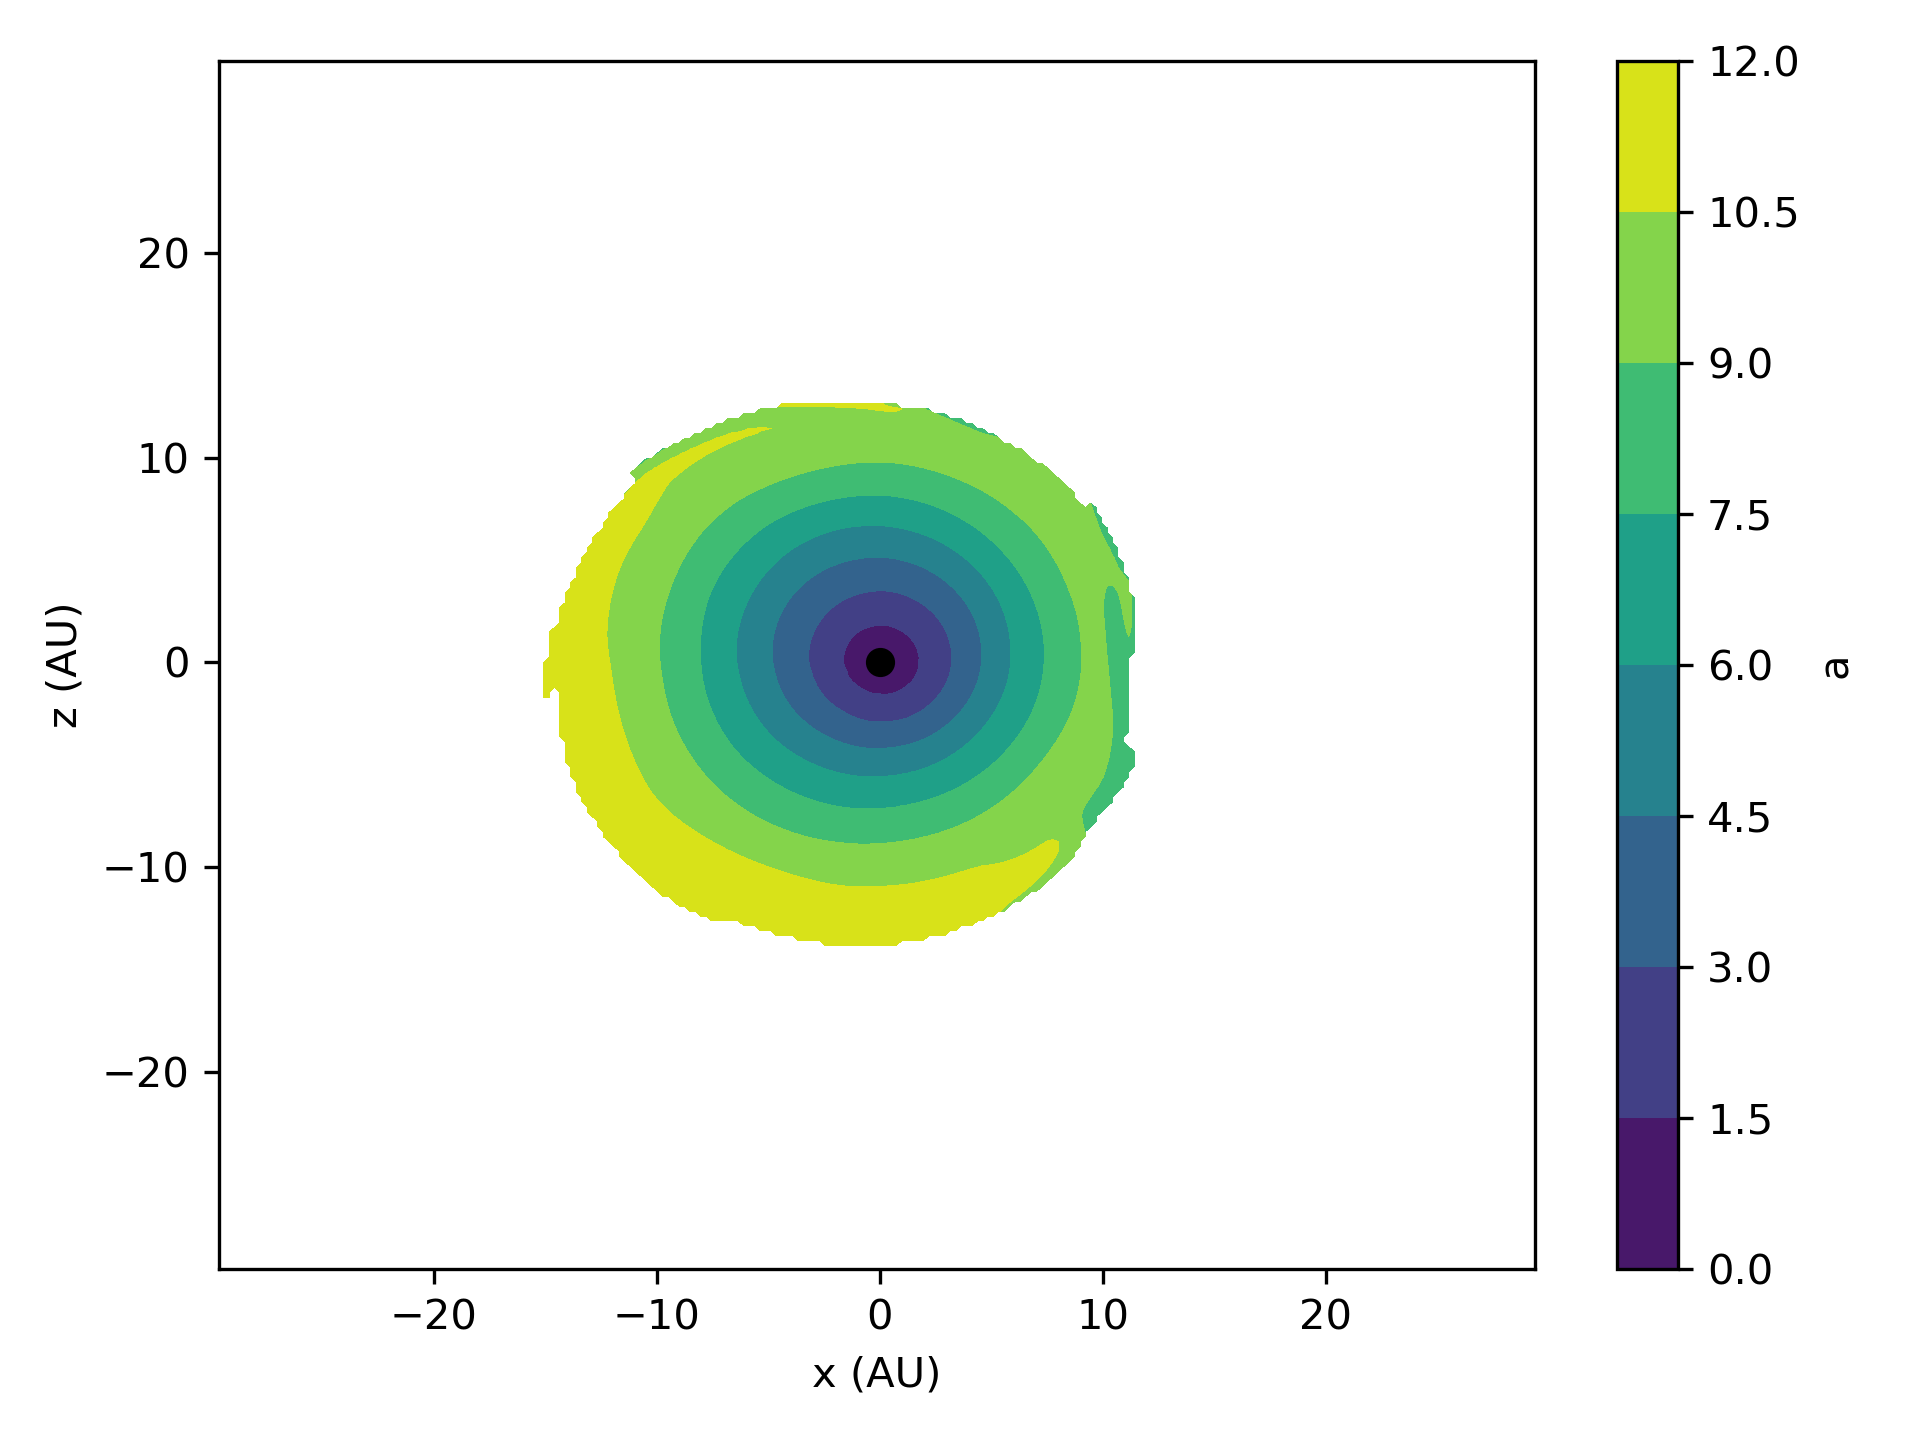

In [8]:
a_grid=disctools.disc_analysis.get_a_on_grid(0.264*1.989E33,cut_cube,cut_velocity,cut_density)*convert.cm_to_au
fig, (map_plot) = plt.subplots()
#ecc_plot.set_figheight(10)
#map_plot.set_aspect(1)
#c = map_plot.pcolormesh(cube_au[1:-1,peak[1],1:-1,0], cube_au[1:-1,peak[1],1:-1,2], a_grid[1:-1,peak[1],1:-1,], cmap='viridis')
c = map_plot.contourf(cube_au[1:-1,1:-1,peak[2],0], cube_au[1:-1,1:-1,peak[2],1], a_grid[1:-1,1:-1,peak[2]], cmap='viridis')
cbar=fig.colorbar(c, ax=map_plot).set_label("a")
sink_position_point=map_plot.scatter([0.0],[0.0],color="black")
#cont = map_plot.contour(cube_au[5:-5,5:-5,81,0], cube_au[5:-5,5:-5,81,1], np.linalg.norm(angularMom[5:-5,5:-5,81,:],axis=-1)/np.max(np.linalg.norm(angularMom[:,:,81,:])), [0.0001],cmap="magma")

map_plot.set_xlabel("x (AU)")
map_plot.set_ylabel("z (AU)")

plt.tight_layout()

<IPython.core.display.Javascript object>


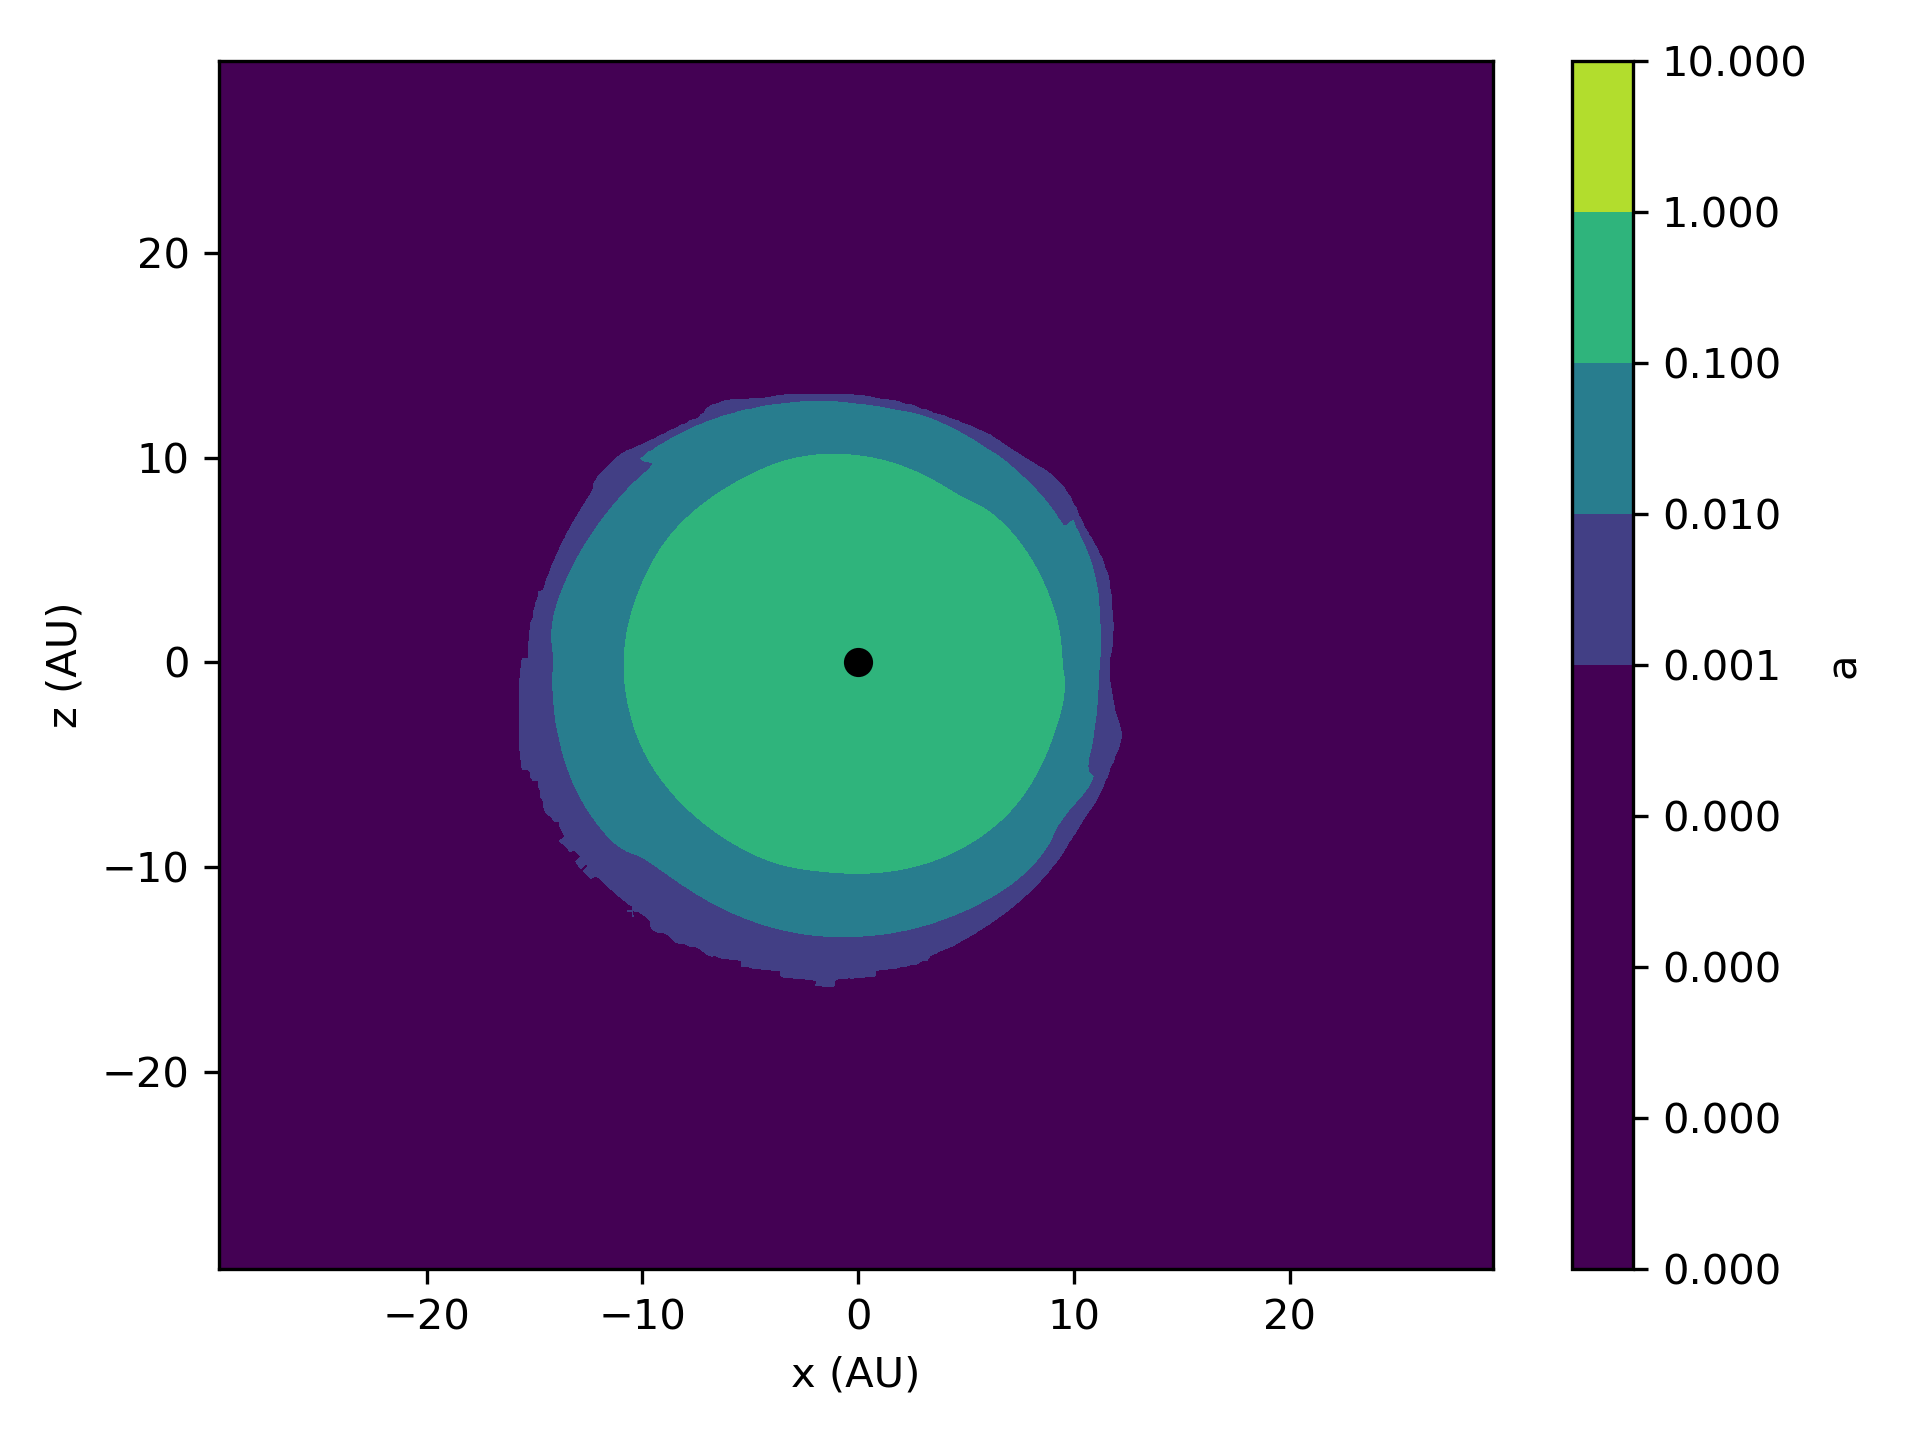

In [9]:
a_grid=disctools.disc_analysis.get_a_on_grid(0.264*1.989E33,cut_cube,cut_velocity,cut_density)*convert.cm_to_au
fig, (map_plot) = plt.subplots()
#ecc_plot.set_figheight(10)
#map_plot.set_aspect(1)
#c = map_plot.pcolormesh(cube_au[1:-1,peak[1],1:-1,0], cube_au[1:-1,peak[1],1:-1,2], a_grid[1:-1,peak[1],1:-1,], cmap='viridis')
c = map_plot.contourf(cube_au[1:-1,1:-1,peak[2],0], cube_au[1:-1,1:-1,peak[2],1], np.linalg.norm(angularMom[1:-1,1:-1,peak[2],:],axis=-1)/np.max(np.linalg.norm(angularMom[1:-1,1:-1,peak[2],:],axis=-1)),norm=colors.LogNorm(vmin=0.0005), cmap='viridis')
cbar=fig.colorbar(c, ax=map_plot).set_label("a")
sink_position_point=map_plot.scatter([0.0],[0.0],color="black")
#cont = map_plot.contour(cube_au[5:-5,5:-5,81,0], cube_au[5:-5,5:-5,81,1], np.linalg.norm(angularMom[5:-5,5:-5,81,:],axis=-1)/np.max(np.linalg.norm(angularMom[:,:,81,:])), [0.0001],cmap="magma")

map_plot.set_xlabel("x (AU)")
map_plot.set_ylabel("z (AU)")

plt.tight_layout()

<IPython.core.display.Javascript object>


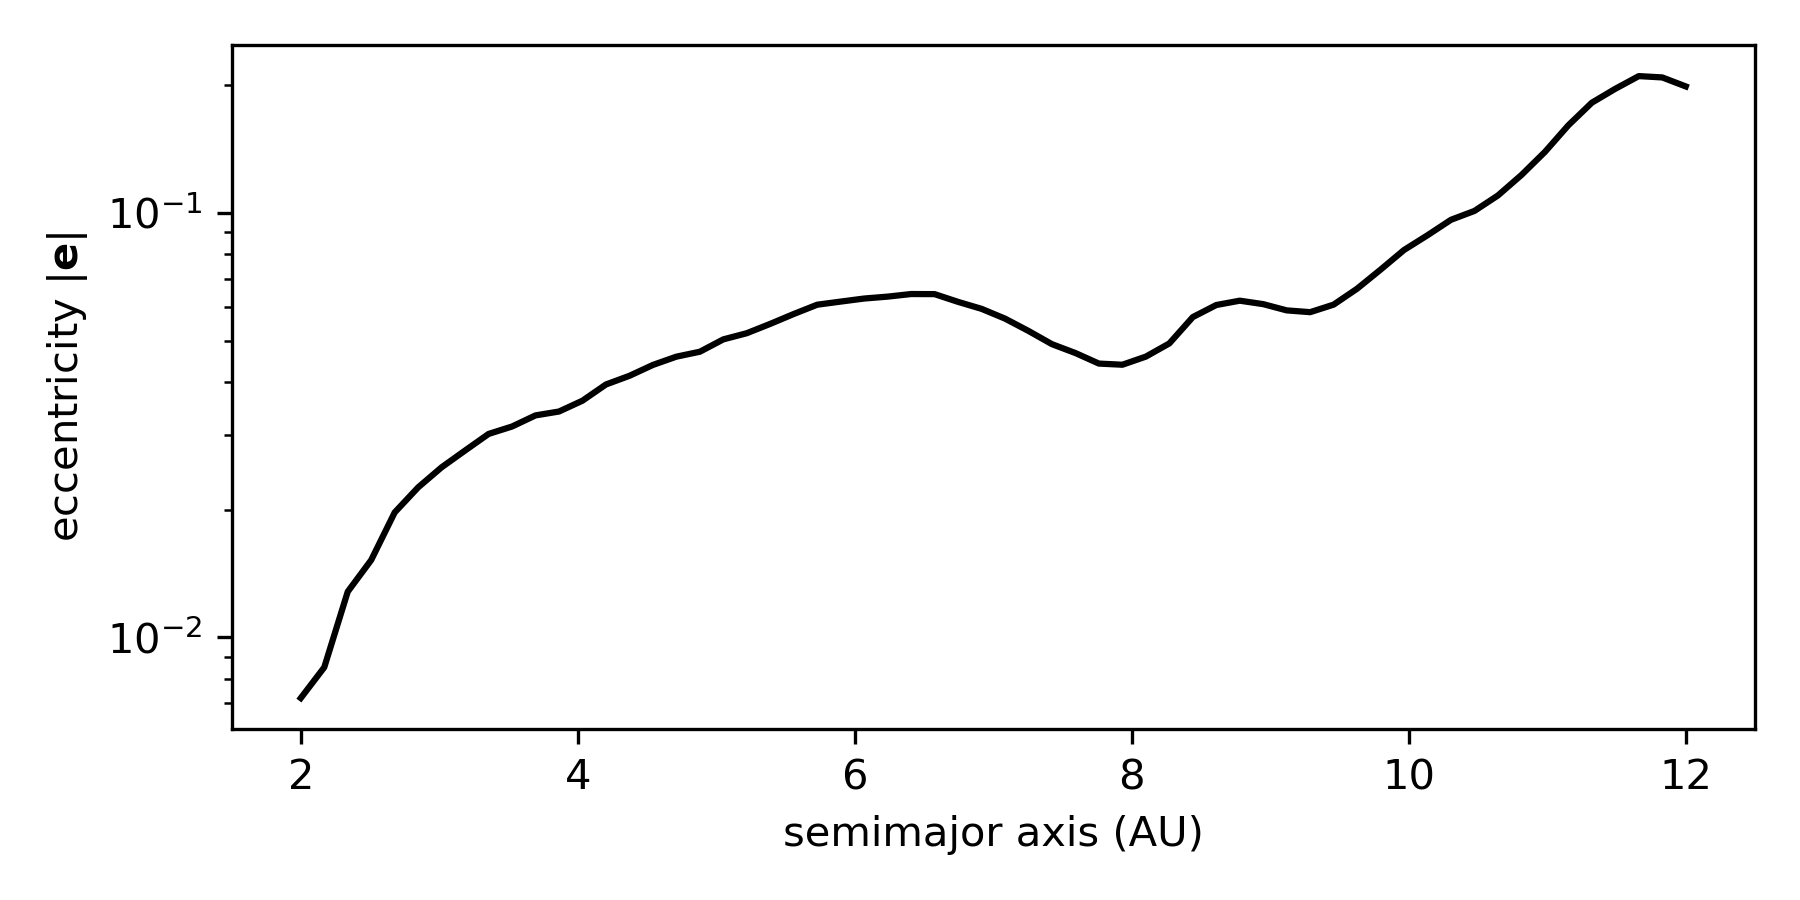

In [10]:
cm_to_au = 6.6845871226706E-14
cube_au=cube*cm_to_au

sink_pos=np.array((0.0,0.0,0.0))
sink_pos.reshape(1,3)
cut_Dens=disctools.disc_cuts.make_cut_array(density,cut_mom_in,angularMom)
cut_density=disctools.disc_cuts.make_cut_array(density,cut_mom_in,angularMom)
cut_velocity=disctools.disc_cuts.make_cut_array(velocity,cut_mom_in,angularMom)
cut_cube=disctools.disc_cuts.make_cut_array(cube,cut_mom_in,angularMom)


radii=np.linspace(2.0,12,60)
e_list=[]
a_grid=disctools.disc_analysis.get_a_on_grid(0.264*1.989E33,cut_cube,cut_velocity,cut_density)*convert.cm_to_au
for a in radii:
    averaged_densities=np.zeros(16)
    #a_mask=disctools.disc_analysis.in_bin(a_grid,disctools.disc_analysis.bin((a-0.2,a+0.2)))
    a_mask=np.where(np.abs(a_grid-a)<0.3,True,False)
    #print(cut_cube[a_mask].shape)
    e=disctools.disc_analysis.mean_eccentricity(0.264*1.989E33,cut_cube[a_mask],cut_velocity[a_mask],cut_density[a_mask])
    #print(e)
    e_list.append(e)
el=np.array([np.linalg.norm(e) for e in e_list])
fig, (ecc_plot) = plt.subplots(figsize=(6,3))

map_plot.set_xlabel("x (AU)")
map_plot.set_ylabel("z (AU)")

ecc_plot.plot(radii,el,color='k')
#ecc_plot.set_ylim(0,0.2)
ecc_plot.set_yscale("log")
ecc_plot.set_xlabel("semimajor axis (AU)")
ecc_plot.set_ylabel("eccentricity |$\mathbf{e}$|")

plt.tight_layout()

In [11]:
e_list=np.array(e_list)

<IPython.core.display.Javascript object>


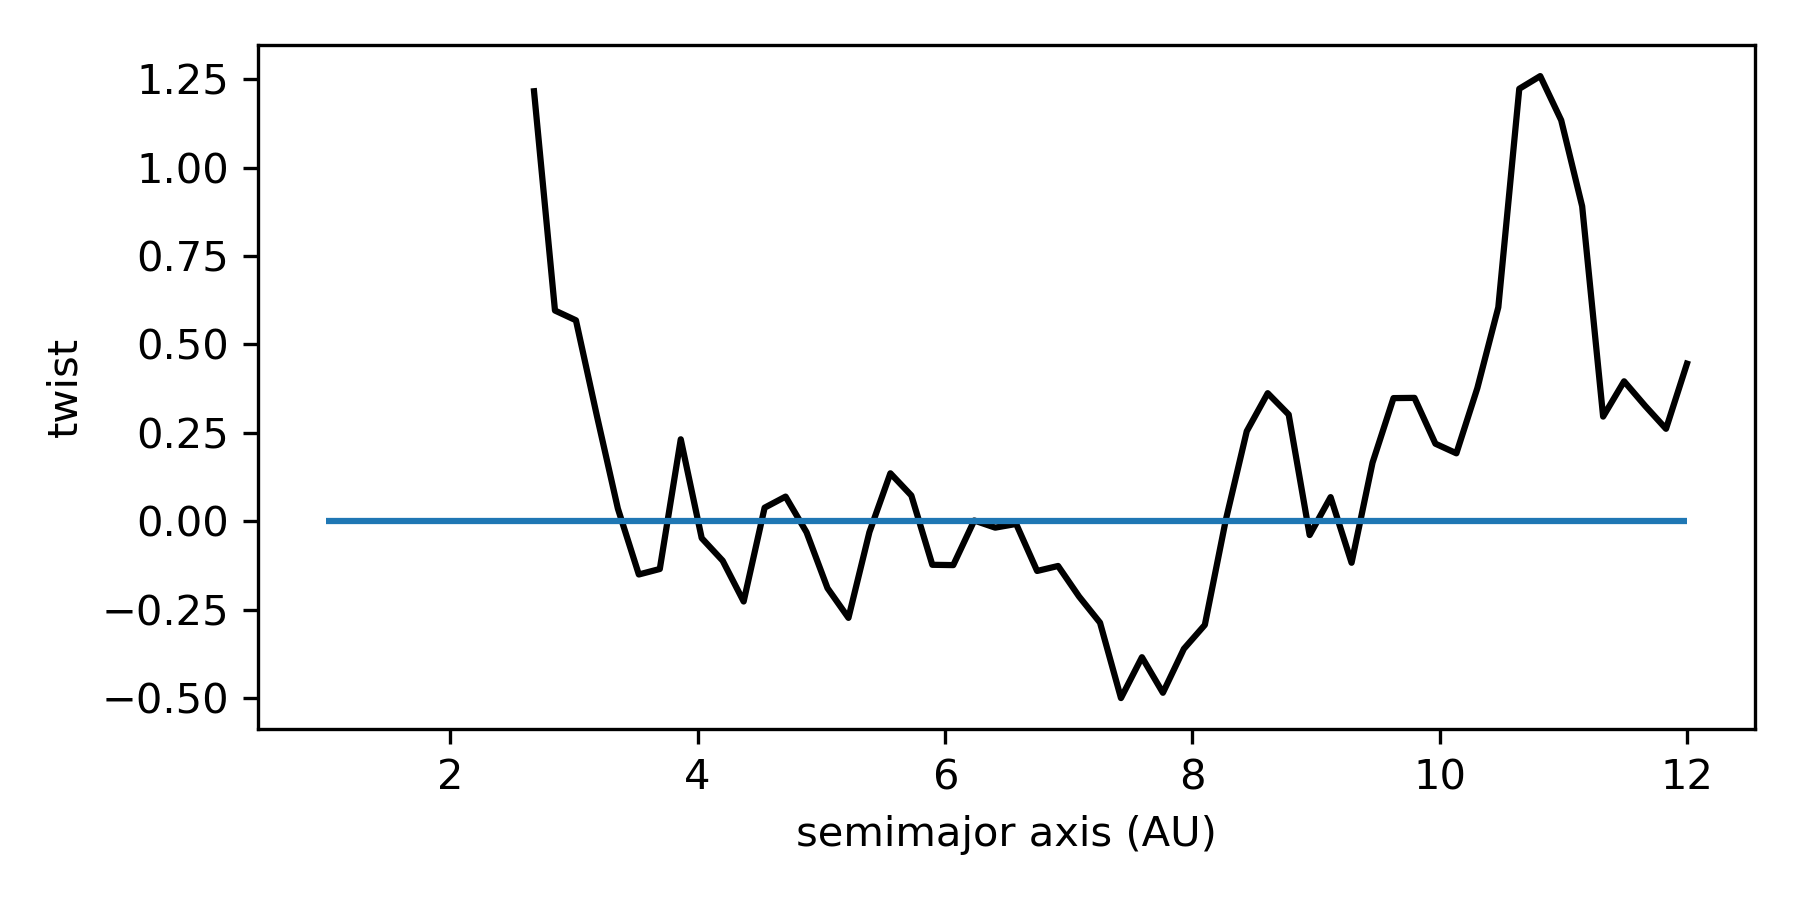

In [12]:
c_list=e_list[:,0]+e_list[:,1]*1j
t_list=np.angle(c_list)
t_prime=(t_list[1:-1]-t_list[0:-2])/(radii[1:-1]-radii[0:-2])

fig, (ecc_plot) = plt.subplots(figsize=(6,3))

map_plot.set_xlabel("x (AU)")
map_plot.set_ylabel("z (AU)")

ecc_plot.plot(radii[4:],t_prime[2:],color='k')
ecc_plot.hlines(0,1,12)
#ecc_plot.set_ylim(0,0.2)
#ecc_plot.set_yscale("log")
ecc_plot.set_xlabel("semimajor axis (AU)")
ecc_plot.set_ylabel("twist")

plt.tight_layout()

In [13]:
?plt.hlines

In [14]:
earr=np.array(e_list)
earr[:]

array([[ 3.72669846e-03, -2.92048822e-04,  6.14791432e-03],
       [ 4.85866767e-03, -5.32434197e-03,  4.50960660e-03],
       [ 9.47995461e-03, -7.89359470e-03,  3.47516324e-03],
       [ 1.31957933e-02, -7.00808631e-03,  2.88904312e-03],
       [ 1.80817137e-02, -7.37307150e-03,  2.61971789e-03],
       [ 2.14857833e-02, -6.43110495e-03,  2.56077142e-03],
       [ 2.43120338e-02, -5.95758492e-03,  2.65093804e-03],
       [ 2.67149019e-02, -6.37373326e-03,  2.40834318e-03],
       [ 2.90919557e-02, -7.72961400e-03,  1.92381691e-03],
       [ 3.01016369e-02, -8.73916714e-03,  1.92164816e-03],
       [ 3.23294131e-02, -8.02254135e-03,  1.74549128e-03],
       [ 3.29593642e-02, -8.46180760e-03,  1.57482492e-03],
       [ 3.47985760e-02, -9.63840714e-03,  1.18844139e-03],
       [ 3.75780629e-02, -1.19809594e-02,  6.99581994e-04],
       [ 3.94692782e-02, -1.23011363e-02,  5.55998420e-04],
       [ 4.20223379e-02, -1.25528155e-02,  2.48246659e-04],
       [ 4.38835276e-02, -1.33605103e-02

In [15]:
@njit
def get_rad_v(velocity,position):
    nx,ny,nz,_=position.shape
    rv=np.zeros((nx,ny,nz))
    for i in prange(nx):
        for j in range(ny):
            for k in range(nz):
                rv[i,j,k]=-velocity[i,j,k,:]@position[i,j,k,:]/np.linalg.norm(position[i,j,k,:])
    return rv

@njit
def cut_mom_in(momentum):
    absmom=np.abs(momentum[:,:,:,2])
    return absmom>0.005*np.max(absmom)

@njit
def cut_mom_out(momentum):
    absmom=np.abs(momentum[:,:,:,2])
    return absmom<0.005*np.max(absmom)

<IPython.core.display.Javascript object>


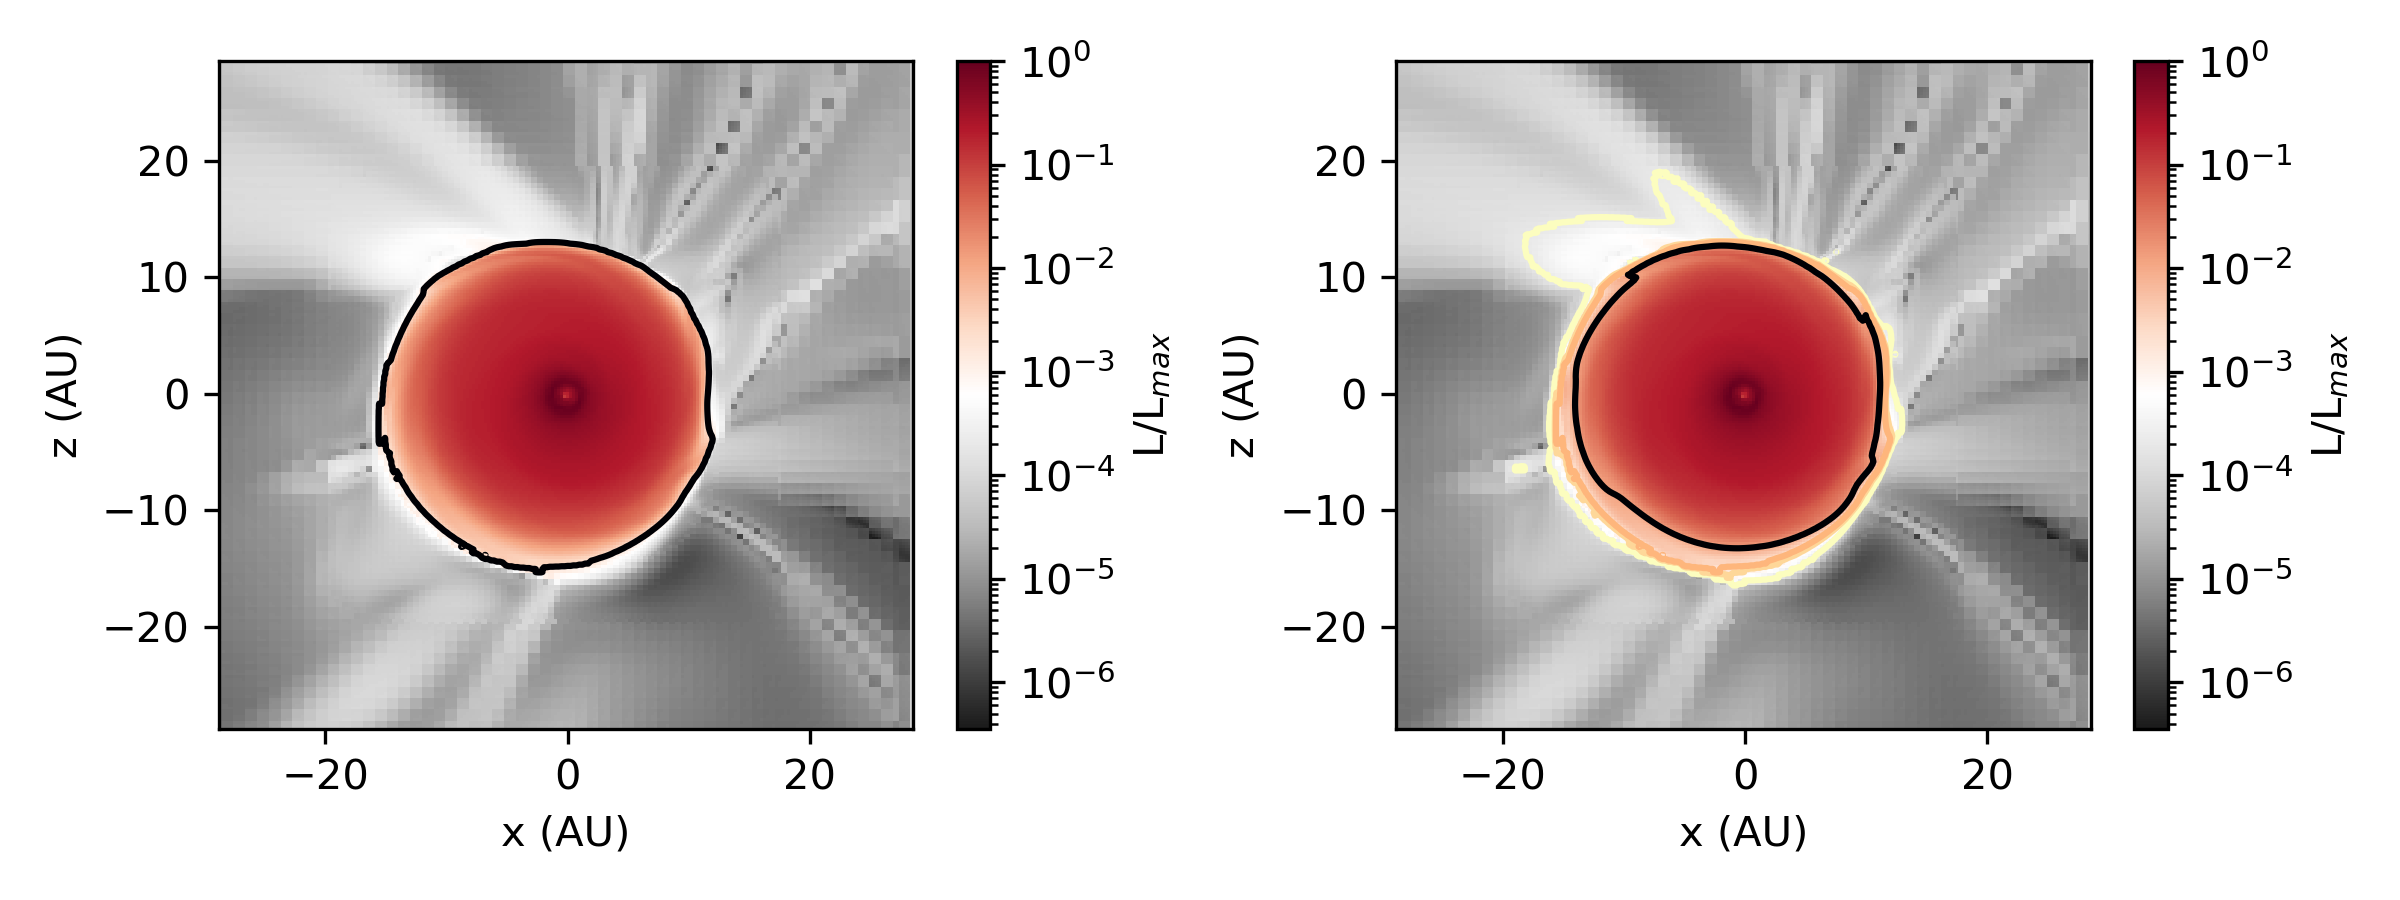

In [16]:
fig, (ax,ax1) = plt.subplots(1,2,figsize=(8,3),gridspec_kw={'width_ratios': [1, 1]})
#ecc_plot.set_figheight(10)
#map_plot.set_aspect(1)
c = ax.pcolormesh(cube_au[5:-5,5:-5,peak[2],0], cube_au[5:-5,5:-5,peak[2],1], np.linalg.norm(angularMom[5:-5,5:-5,peak[2],:],axis=-1)/np.max(np.linalg.norm(angularMom[:,:,peak[2],:],axis=-1)),norm=colors.LogNorm(), cmap='RdGy_r')
cbar=fig.colorbar(c, ax=ax).set_label("L/L$_{max}$")
cont = ax.contour(cube_au[5:-5,5:-5,peak[2],0], cube_au[5:-5,5:-5,peak[2],1], np.linalg.norm(angularMom[5:-5,5:-5,peak[2],:],axis=-1)/np.max(np.linalg.norm(angularMom[:,:,peak[2],:])), [0.0001],cmap="magma")
#cbar.clim(vmax=cut_beta.max(), vmin=1./cut_beta.max())
ax.set_xlabel("x (AU)")
ax.set_ylabel("z (AU)")

c = ax1.pcolormesh(cube_au[5:-5,5:-5,peak[2],0], cube_au[5:-5,5:-5,peak[2],1], np.linalg.norm(angularMom[5:-5,5:-5,peak[2],:],axis=-1)/np.max(np.linalg.norm(angularMom[:,:,peak[2],:],axis=-1)),norm=colors.LogNorm(), cmap='RdGy_r')
cbar=fig.colorbar(c, ax=ax1).set_label("L/L$_{max}$")
cont = ax1.contour(cube_au[5:-5,5:-5,peak[2],0], cube_au[5:-5,5:-5,peak[2],1], np.linalg.norm(angularMom[5:-5,5:-5,peak[2],:],axis=-1)/np.max(np.linalg.norm(angularMom[:,:,peak[2],:])), [0.00001,0.00006,0.0001,0.0006],cmap="magma_r")
#cbar.clim(vmax=cut_beta.max(), vmin=1./cut_beta.max())
ax1.set_xlabel("x (AU)")
ax1.set_ylabel("z (AU)")
plt.tight_layout()

In [17]:
@njit
def get_rad_v(velocity,position):
    nx,ny,nz,_=position.shape
    rv=np.zeros((nx,ny,nz))
    for i in prange(nx):
        for j in range(ny):
            for k in range(nz):
                rv[i,j,k]=-velocity[i,j,k,:]@position[i,j,k,:]/np.linalg.norm(position[i,j,k,:])
    return rv

@njit
def get_e_loc(L,a):
    nx,ny,nz,_=L.shape
    rv=np.zeros((nx,ny,nz))
    for i in prange(nx):
        for j in range(ny):
            for k in range(nz):
                rv[i,j,k]=np.sqrt(1.0-L[i,j,k]@L[i,j,k]/(0.264*1.989E33*a[i,j,k]))
    return rv

@njit
def get_in_sink(x,dx):
    nx,ny,nz,_=x.shape
    iis=np.zeros((nx,ny,nz))
    for i in prange(nx):
        for j in range(ny):
            for k in range(nz):
                if np.linalg.norm(x[i,j,k])<4*dx:
                    iis[i,j,k]=1
    return iis



#ee=get_e_loc(angularMom,a_grid)

In [18]:
radii=np.linspace(1.0,12,100)
rv_list=[]
a_grid=disctools.disc_analysis.get_a_on_grid(0.264*1.989E33,cube_au,velocity,density)
for a in radii:
    averaged_densities=np.zeros(16)
    a_mask=np.where(np.abs(a_grid-a)<0.1,True,False)
    rv=np.sum([-1*dens*np.dot(vel,pos)/np.linalg.norm(pos) for vel,dens,pos in zip(velocity[a_mask],density[a_mask],cube[a_mask])])
    rv_list.append(rv*5.0)

<IPython.core.display.Javascript object>


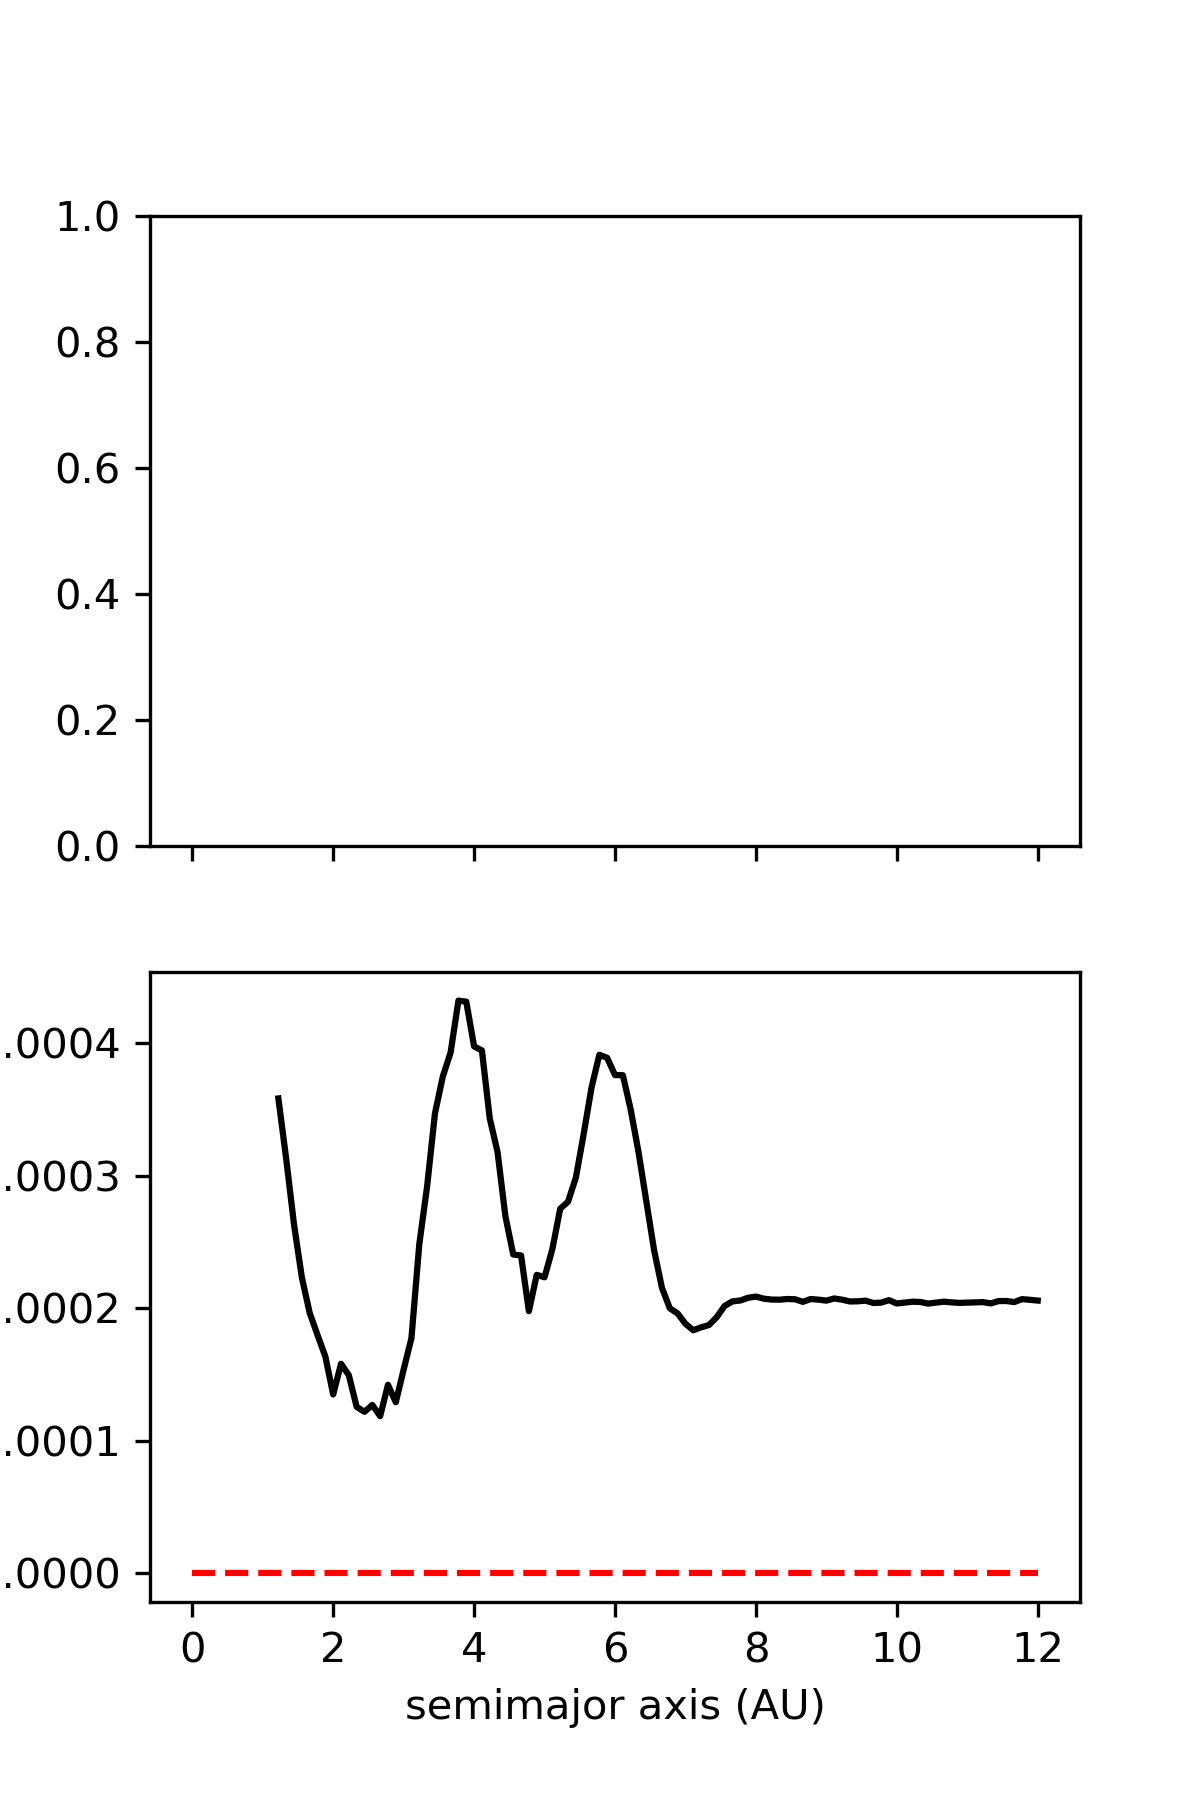

NameError: name 'radii_midplane' is not defined

In [19]:
fig, ((midplane,integrated)) = plt.subplots(2,1,figsize=(4,6),gridspec_kw={'height_ratios': [1, 1]},sharex=True)
integrated.plot(radii[2:],rv_list[2:],color='k')
integrated.set_xlabel("semimajor axis (AU)")
integrated.set_ylabel("integrated radial density flux")
integrated.hlines(0,xmin=0,xmax=radii[-1],linestyle="dashed", color="red")
integrated.ticklabel_format(style="sci")

midplane.plot(radii_midplane[2:],rv_list_midplane[2:],color='k')
#midplane.set_xlabel("semimajor axis (AU)")
midplane.hlines(0,xmin=0,xmax=radii[-1],linestyle="dashed", color="red")
midplane.set_ylabel("midplane radial density flux")
plt.tight_layout()

<IPython.core.display.Javascript object>


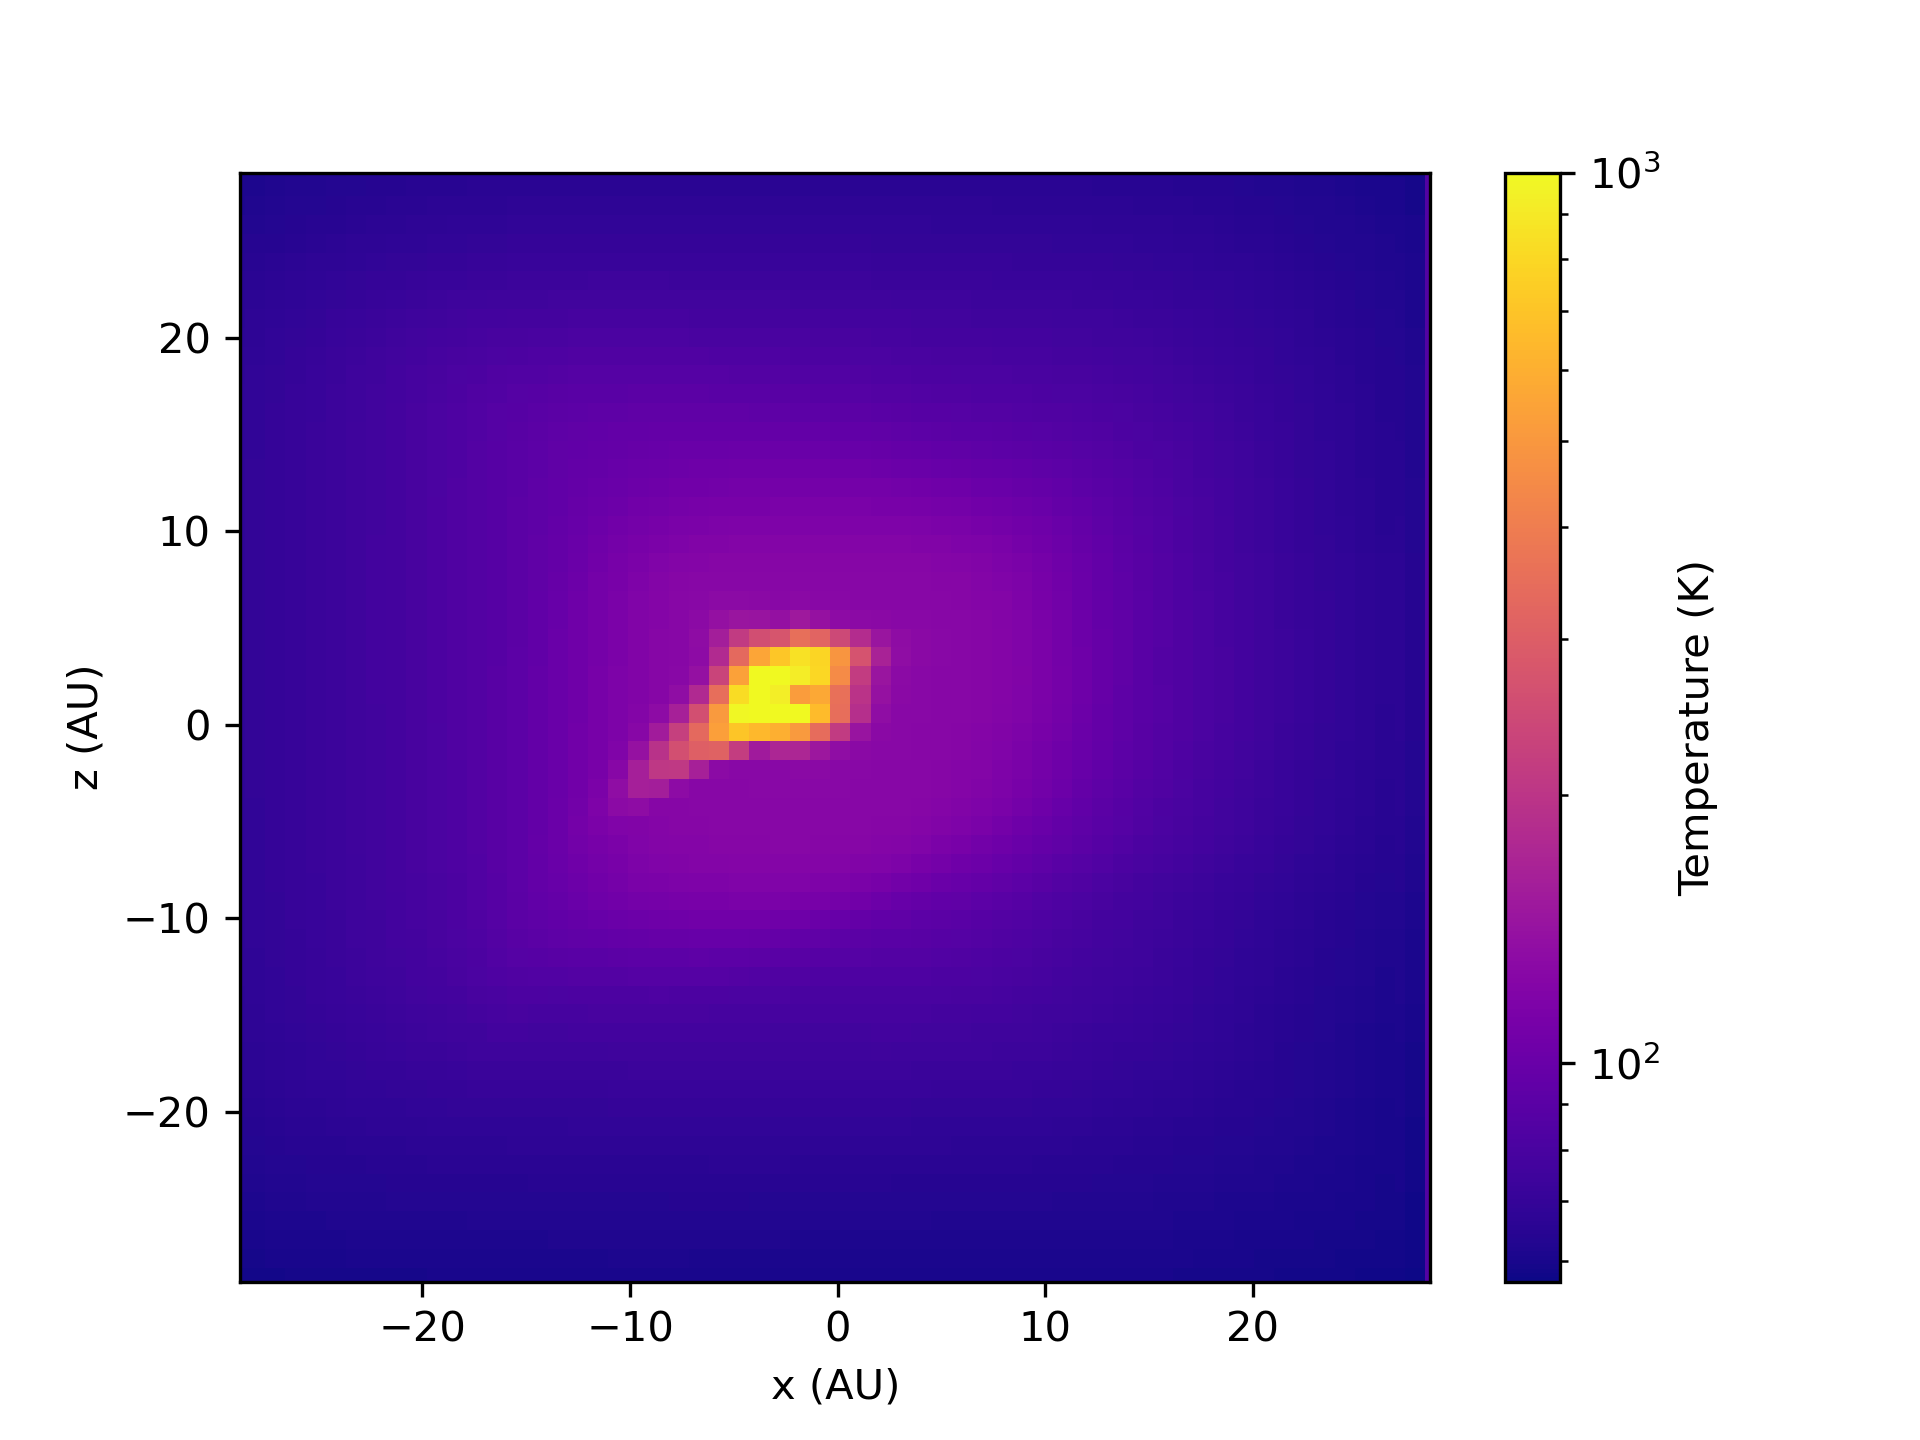

Text(0, 0.5, 'z (AU)')

In [20]:
temperature=disctools.datacube.fill_array_scalar(data["hydro"]["temperature"].values,imap)
fig, ax = plt.subplots()
#ecc_plot.set_figheight(10)
#map_plot.set_aspect(1)
c = ax.pcolormesh(cube_au[5:-5,5:-5,81,0], cube_au[5:-5,5:-5,81,1], temperature[5:-5,5:-5,81],norm=colors.LogNorm(vmax=1000),cmap='plasma')
cbar=fig.colorbar(c, ax=ax).set_label("Temperature (K)")
ax.set_xlabel("x (AU)")
ax.set_ylabel("z (AU)")

<IPython.core.display.Javascript object>


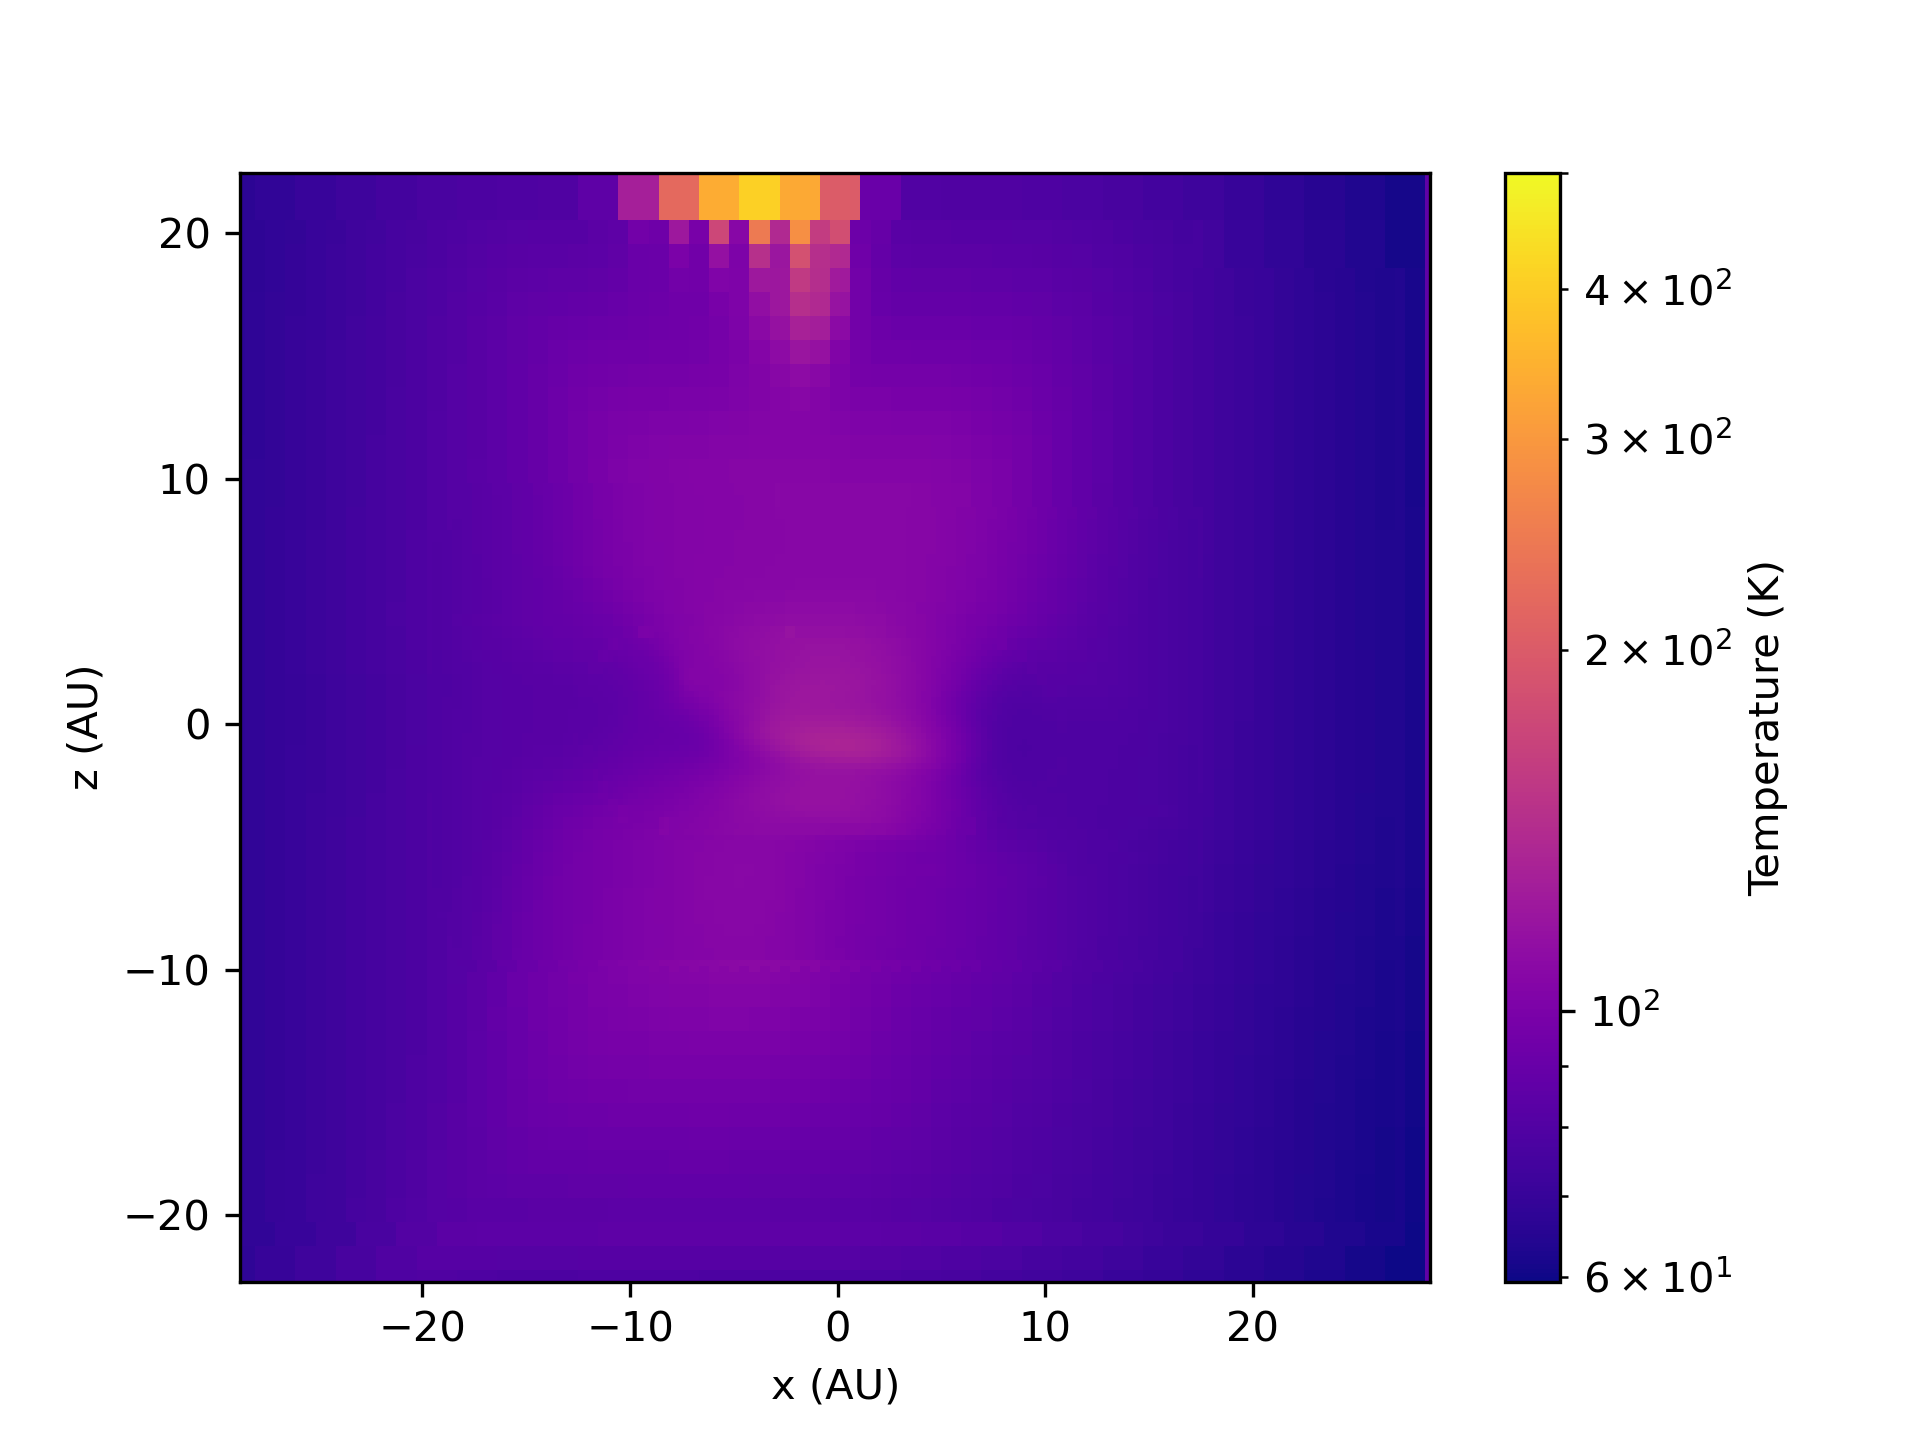

Text(0, 0.5, 'z (AU)')

In [21]:
temperature=disctools.datacube.fill_array_scalar(data["hydro"]["temperature"].values,imap)
fig, ax = plt.subplots()
#ecc_plot.set_figheight(10)
#map_plot.set_aspect(1)
c = ax.pcolormesh(cube_au[5:-5,81,30:-30,0], cube_au[5:-5,81,30:-30,2], temperature[5:-5,81,30:-30],norm=colors.LogNorm(vmax=500), cmap='plasma')
cbar=fig.colorbar(c, ax=ax).set_label("Temperature (K)")
ax.set_xlabel("x (AU)")
ax.set_ylabel("z (AU)")

In [22]:
data = osyris.Dataset(1616, path=".").load()
data=osyris.extract_box(data,dx=100*osyris.units("au"), dy=100*osyris.units("au"), dz=100*osyris.units("au"), origin=data["sink"]["position"])
data["amr"]["position"]=data["amr"]["position"]-data["sink"]["position"]
imp.reload(disctools.datacube)

dx=(np.min(data["amr"]["dx"].values),np.min(data["amr"]["dx"].values),np.min(data["amr"]["dx"].values))
l=(100*convert.au_to_cm,100*convert.au_to_cm,100*convert.au_to_cm)
s=(-50*convert.au_to_cm,-50*convert.au_to_cm,-50*convert.au_to_cm)
cube=disctools.datacube.make_cube(dx,l,s)
print(cube.shape)

positionArray=np.stack((data["amr"]["position"].x.values,data["amr"]["position"].y.values,data["amr"]["position"].z.values),axis=-1)
imap=disctools.datacube.make_amr_mapping(positionArray,cube,data["amr"]["level"].values)
density=disctools.datacube.fill_array_scalar(data["hydro"]["density"].values,imap)
velocity=disctools.datacube.fill_array_vector(data["hydro"]["velocity"].x.values,data["hydro"]["velocity"].y.values,data["hydro"]["velocity"].z.values,imap)
angularMom=disctools.disc_analysis.angular_momentum(velocity,density,1.0,cube)
totmom=disctools.disc_analysis.angular_momentum_sphere(velocity,density,1.0,cube)

cm_to_au = 6.6845871226706E-14
cube_au=cube*cm_to_au

sink_pos=np.array((0.0,0.0,0.0))
sink_pos.reshape(1,3)

Processing 128 files in ./output_01616
 10% : read     171136 cells,         17 particles
 20% : read     486595 cells,        127 particles
 30% : read     679371 cells,        292 particles
 40% : read     742280 cells,        343 particles
 50% : read     796120 cells,       2147 particles
 60% : read     873537 cells,       2155 particles
 70% : read     946010 cells,      11560 particles
 80% : read    1004717 cells,      12491 particles
 90% : read    1856884 cells,      13018 particles
Loaded: 3095240 cells, 13309 particles.
(411, 411, 411, 3)
building amr level 12
building amr level 13
building amr level 14
building amr level 15
building amr level 16


array([[0., 0., 0.]])

In [23]:
peak=np.unravel_index(np.argmax(density),density.shape)

In [ ]:
temperature=disctools.datacube.fill_array_scalar(data["hydro"]["temperature"].values,imap)
fig, ax = plt.subplots()
#ecc_plot.set_figheight(10)
#map_plot.set_aspect(1)
c = ax.pcolormesh(cube_au[5:-5,peak[1],:,0], cube_au[5:-5,peak[1],:,2], temperature[5:-5,peak[1],:],norm=colors.LogNorm(vmax=2000), cmap='plasma')
cbar=fig.colorbar(c, ax=ax).set_label("Temperature (K)")
ax.set_xlabel("x (AU)")
ax.set_ylabel("z (AU)")

In [24]:
velocity=disctools.datacube.fill_array_vector(data["hydro"]["velocity"].x.values,data["hydro"]["velocity"].y.values,data["hydro"]["velocity"].z.values,imap)

In [25]:
density=disctools.datacube.fill_array_scalar(data["hydro"]["density"].values,imap)

<IPython.core.display.Javascript object>


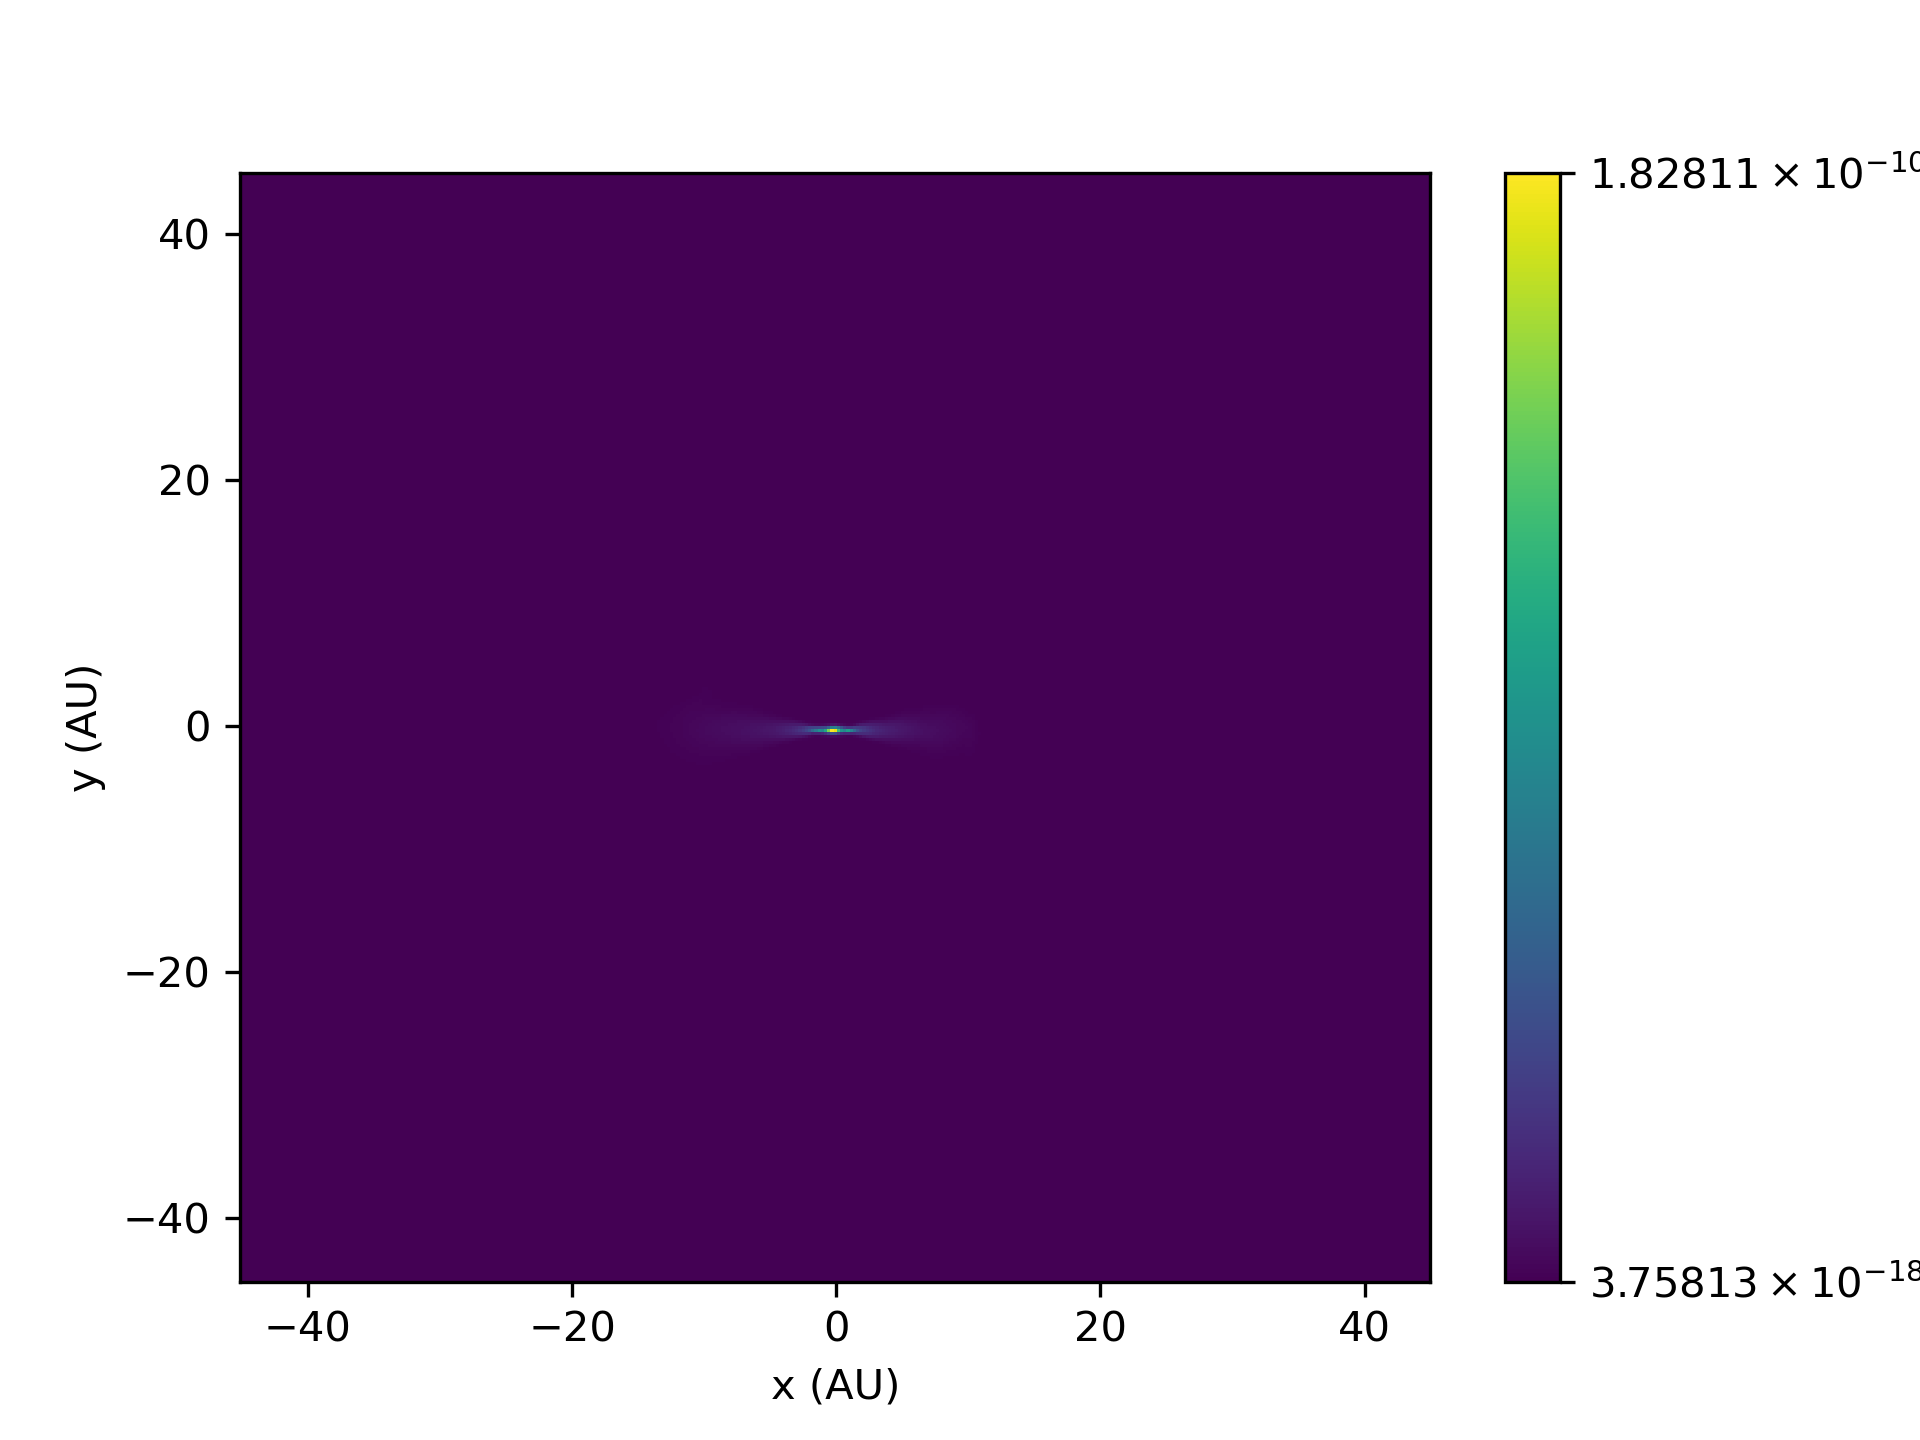

Text(0, 0.5, 'y (AU)')

In [27]:
#density=0.25
#scale=int(np.ceil(1/density))
rv=get_rad_v(velocity,cube)
fig, ax = plt.subplots()
c = ax.pcolormesh(cube_au[20:-20,peak[1],20:-20,0], cube_au[20:-20,peak[1],20:-20,2], (density[20:-20,peak[1],20:-20]),norm=colors.SymLogNorm(linthresh = 1.0), cmap='viridis')
fig.colorbar(c, ax=ax).set_label("$\mathbf{v}\cdot\mathbf{\hat{r}}$ ($\mathrm{cm\cdot s}^{-1}$)")
#d = ax.quiver(cube_au[20:-20:scale,82,20:-20:scale,0], cube_au[20:-20:scale,82,20:-20:scale,2],velocity[20:-20:scale,82,20:-20:scale,0],velocity[20:-20:scale,82,10:-10:scale,2],scale=1.5e7)
ax.set_xlabel("x (AU)")
ax.set_ylabel("y (AU)")

<IPython.core.display.Javascript object>


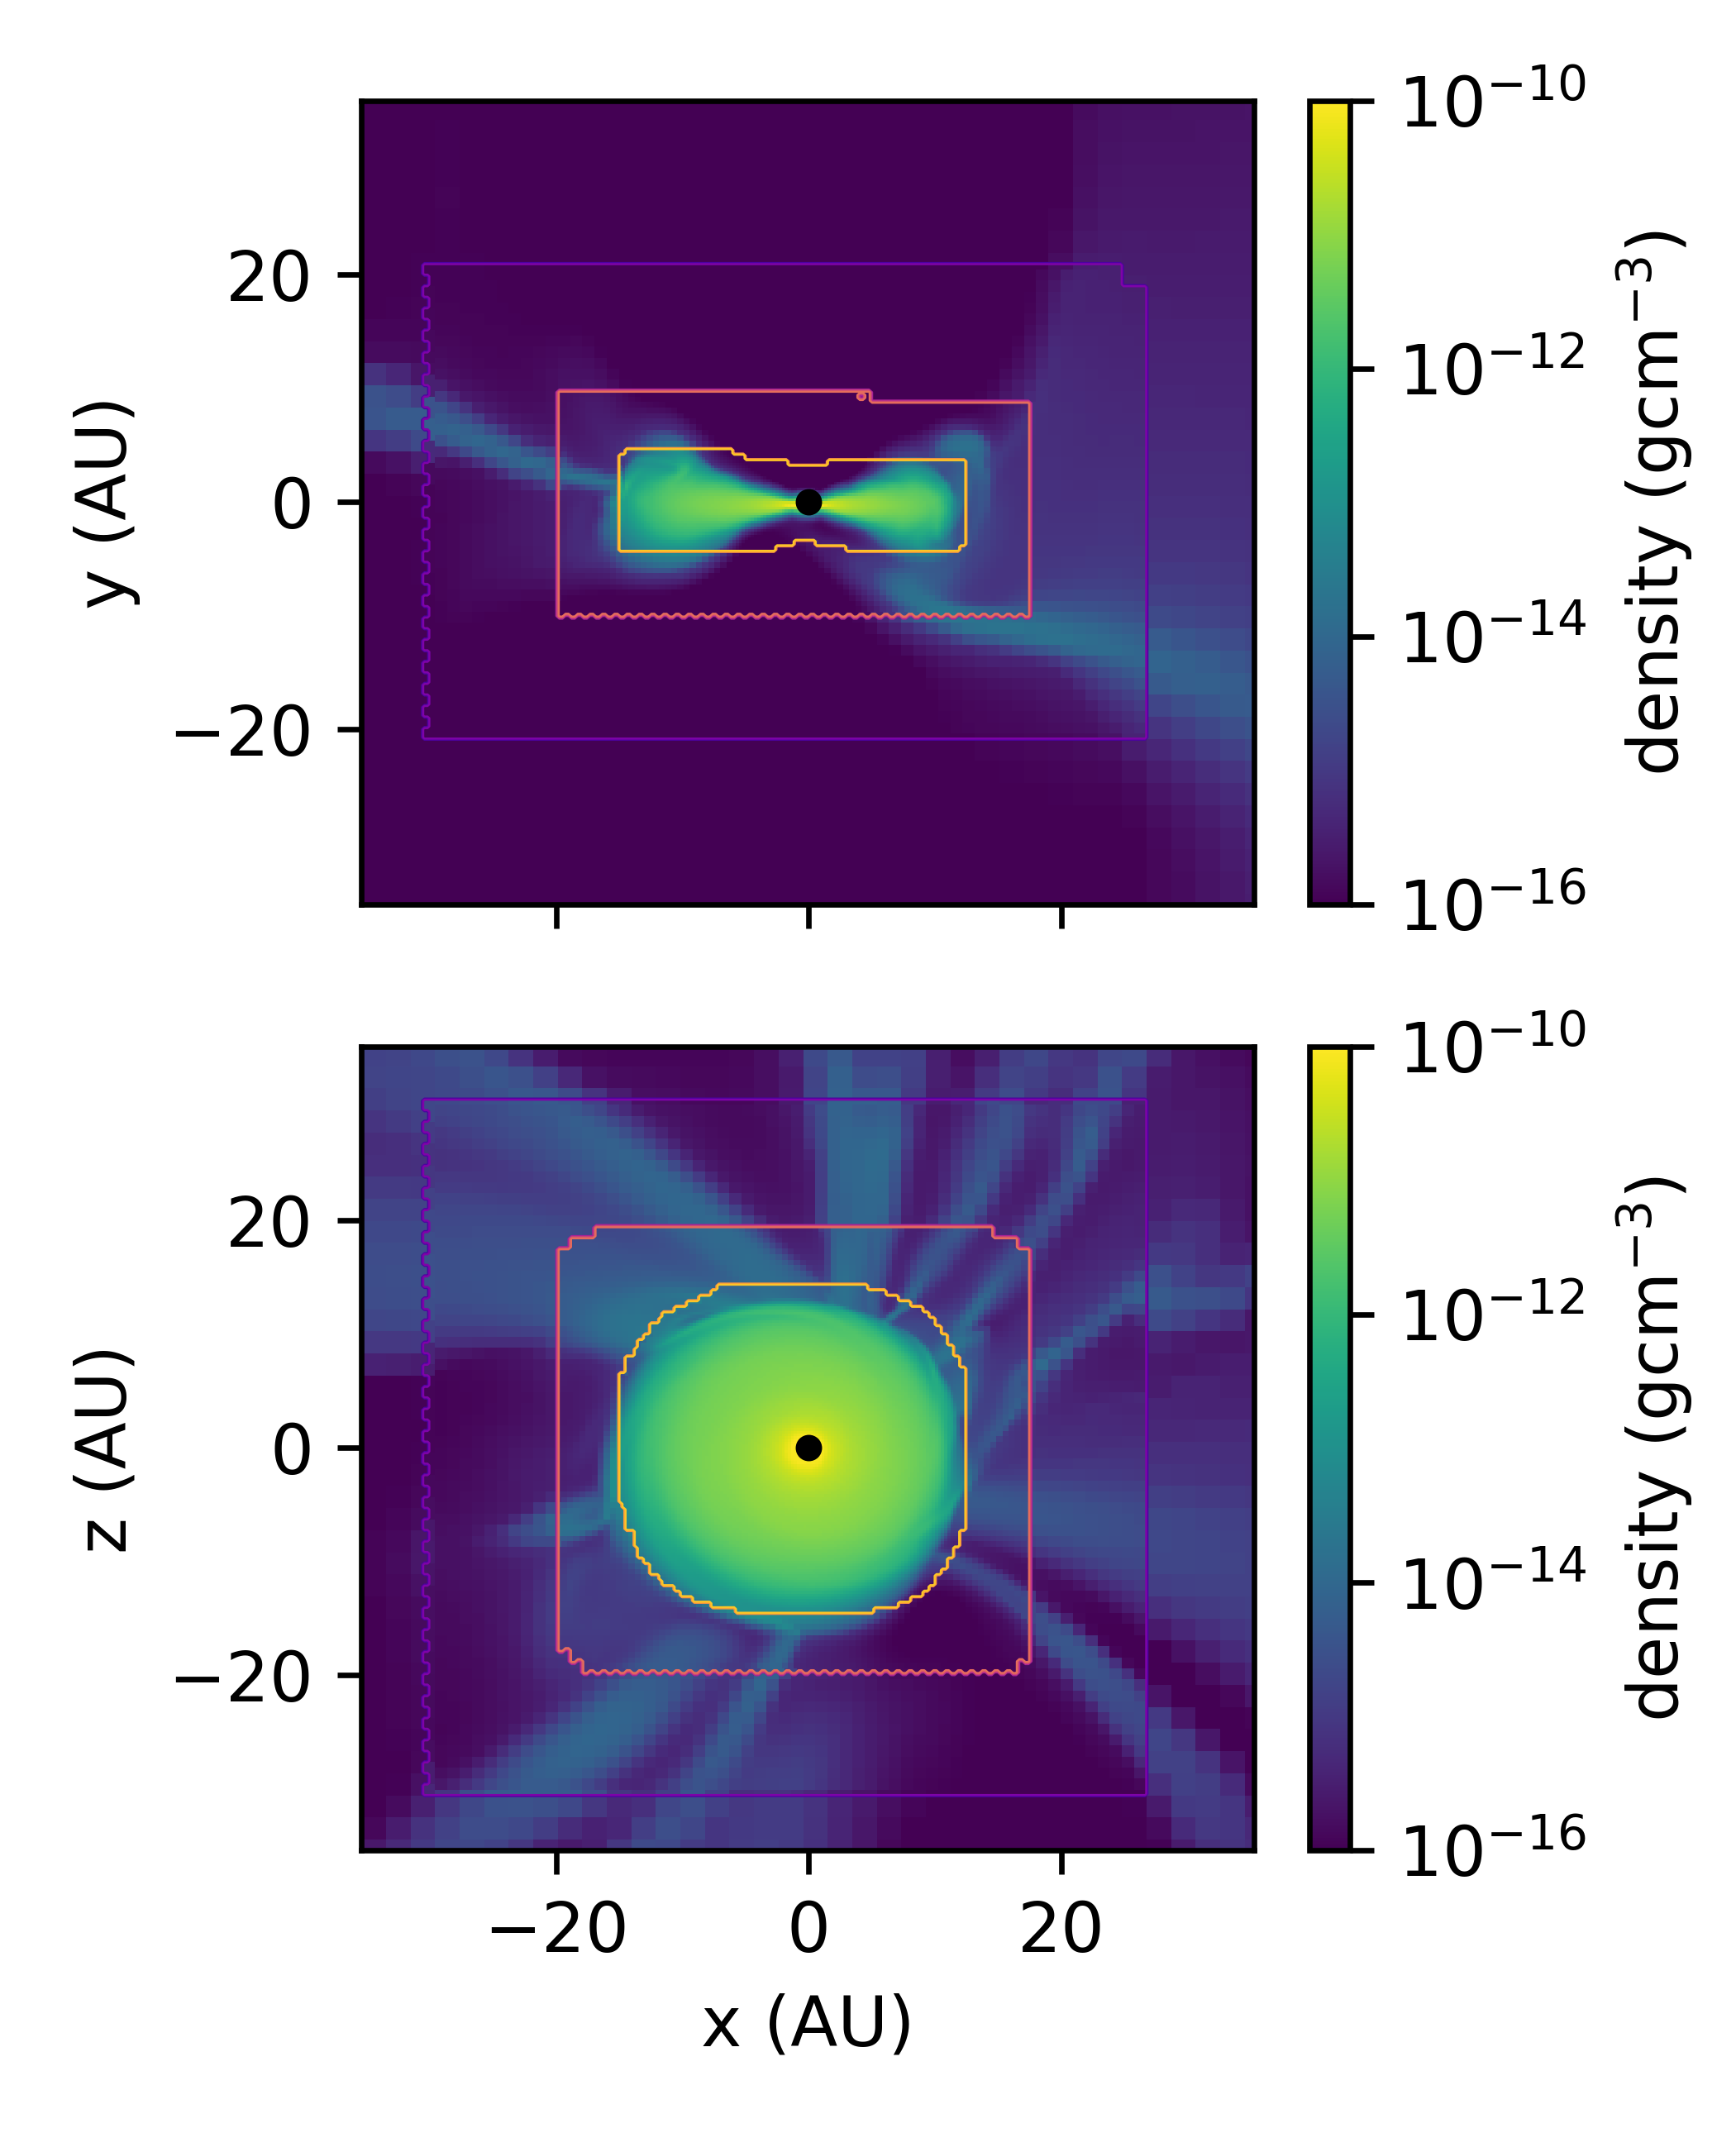

In [76]:
level=disctools.datacube.fill_array_scalar(data["amr"]["level"].values,imap)
in_sink=get_in_sink(cube,dx[0])

fig, ((map_plot1,map_plot2)) = plt.subplots(2,1,figsize=(3.5,4.3),gridspec_kw={'height_ratios': [1, 1]})
#ecc_plot.set_figheight(10)
#map_plot.set_aspect(1)

clip=60

c = map_plot1.pcolormesh(cube_au[clip:-clip,peak[1],clip:-clip,0], cube_au[clip:-clip,peak[1],clip:-clip,2],density[clip:-clip,peak[1],clip:-clip],norm=colors.LogNorm(vmin=1e-16,vmax=1e-10), cmap='viridis')
d = map_plot1.contour(cube_au[clip:-clip,peak[1],clip:-clip,0], cube_au[clip:-clip,peak[1],clip:-clip,2],level[clip:-clip,peak[1],clip:-clip],linewidths=[0.3], cmap='plasma')
#e = map_plot1.contourf(cube_au[clip:-clip,peak[1],clip:-clip,0], cube_au[clip:-clip,peak[1],clip:-clip,2],in_sink[clip:-clip,peak[1],clip:-clip],linewidths=[0.5], cmap='magma_r')
cbar=fig.colorbar(c, ax=map_plot1).set_label("density ($\mathrm{g} \mathrm{cm}^{-3}$)")
sink_position_point=map_plot1.scatter([0.0],[0.0],color="black",s=8.0)
#cont = map_plot1.contour(cube_au[5:-5,80,5:-5,0], cube_au[5:-5,80,5:-5,2], np.linalg.norm(angularMom[5:-5,80,5:-5,:],axis=-1)/np.max(np.linalg.norm(angularMom[:,:,:,:])), [0.00005],cmap="magma")

#map_plot1.set_xlabel("x (AU)")
map_plot1.set_ylabel("y (AU)")

c = map_plot2.pcolormesh(cube_au[clip:-clip,clip:-clip,peak[2],0], cube_au[clip:-clip,clip:-clip,peak[2],1], density[clip:-clip,clip:-clip,peak[2]],norm=colors.LogNorm(vmin=1e-16,vmax=1e-10), cmap='viridis')
d = map_plot2.contour(cube_au[clip:-clip,clip:-clip,peak[2],0], cube_au[clip:-clip,clip:-clip,peak[2],1], level[clip:-clip,clip:-clip,peak[2]],linewidths=[0.3], cmap='plasma')
cbar=fig.colorbar(c, ax=map_plot2).set_label("density ($\mathrm{g} \mathrm{cm}^{-3}$)")
sink_position_point=map_plot2.scatter([0.0],[0.0],color="black",s=8.0)
#cont = map_plot2.contour(cube_au[5:-5,5:-5,81,0], cube_au[5:-5,5:-5,81,1], np.linalg.norm(angularMom[5:-5,5:-5,81,:],axis=-1)/np.max(np.linalg.norm(angularMom[:,:,81,:])), [0.0001],cmap="magma")

map_plot2.set_xlabel("x (AU)")
map_plot1.xaxis.set_tick_params(labelbottom=False)
#map_plot2.set_yticks([])
map_plot2.set_ylabel("z (AU)")

plt.tight_layout()

<IPython.core.display.Javascript object>


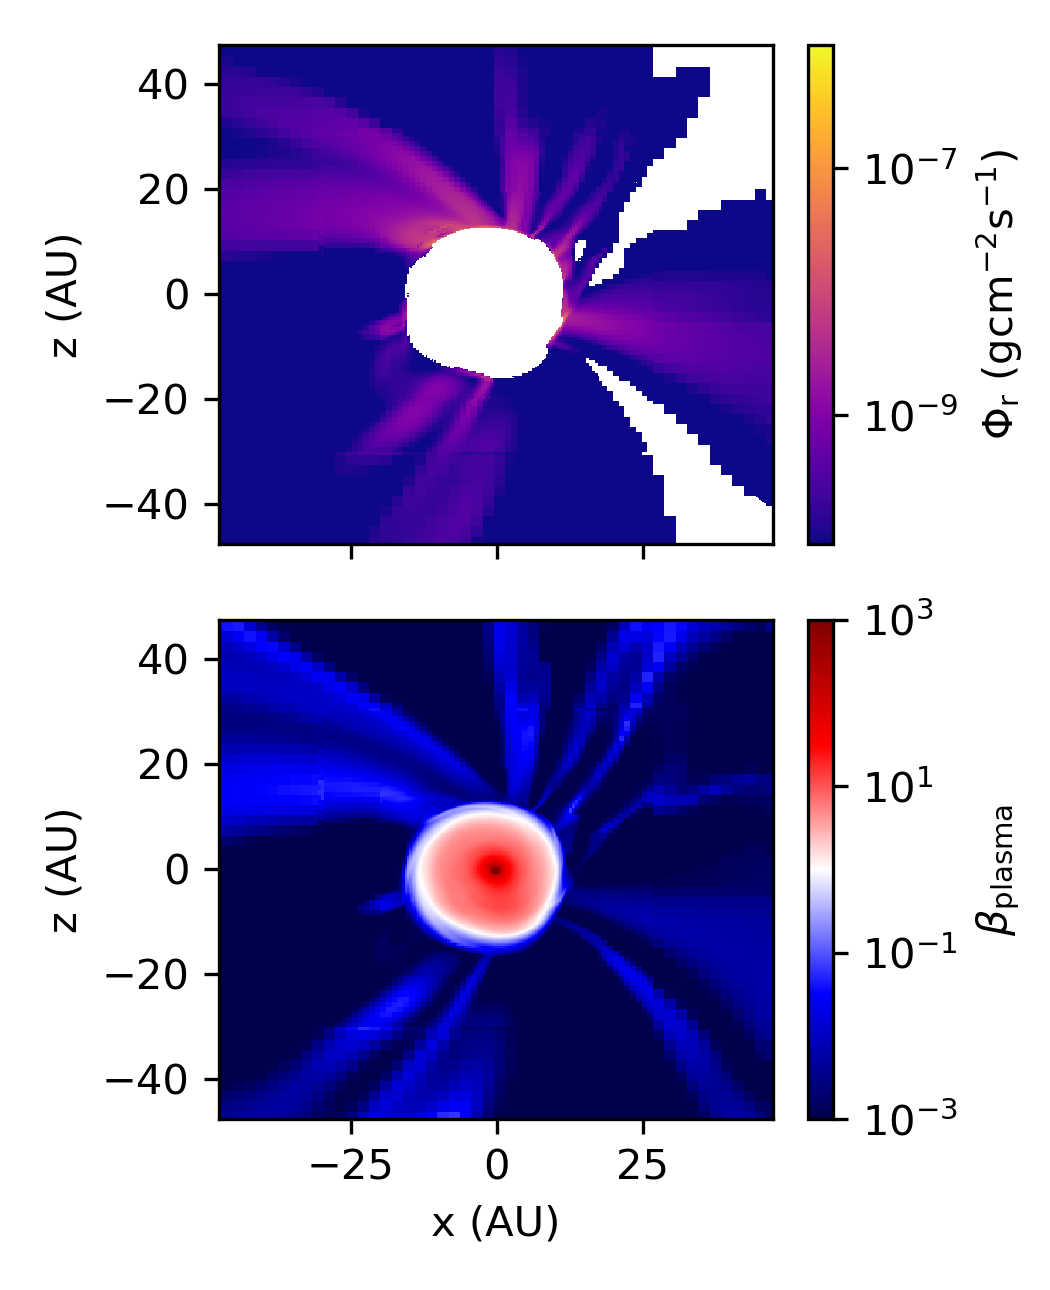

In [29]:
radial_f_out=disctools.disc_cuts.make_cut_array(get_rad_v(velocity,cube)*density,cut_mom_out,angularMom)
data["hydro"]["beta"]=data["hydro"]["thermal_pressure"]/(2*(data["hydro"]["B_field"].dot(data["hydro"]["B_field"])))

level=disctools.datacube.fill_array_scalar(data["amr"]["level"].values,imap)
beta=disctools.datacube.fill_array_scalar(data["hydro"]["beta"].values,imap)

in_sink=get_in_sink(cube,dx[0])

fig, ((map_plot1,map_plot2)) = plt.subplots(2,1,figsize=(3.5,4.3),gridspec_kw={'height_ratios': [1, 1]})
#ecc_plot.set_figheight(10)
#map_plot.set_aspect(1)

clip=10

c = map_plot1.pcolormesh(cube_au[clip:-clip,clip:-clip,peak[2],0], cube_au[clip:-clip,clip:-clip,peak[2],1], radial_f_out[clip:-clip,clip:-clip,peak[2]],norm=colors.LogNorm(vmin=1e-6,vmax=1e-10), cmap='plasma')
#d = map_plot2.contour(cube_au[clip:-clip,clip:-clip,peak[2],0], cube_au[clip:-clip,clip:-clip,peak[2],1], level[clip:-clip,clip:-clip,peak[2]],linewidths=[0.3], cmap='plasma')
cbar=fig.colorbar(c, ax=map_plot1).set_label("$\\Phi_\mathrm{r}$ ($\mathrm{g} \mathrm{cm}^{-2}\mathrm{s}^{-1}$)")
#sink_position_point=map_plot2.scatter([0.0],[0.0],color="black",s=8.0)
#cont = map_plot1.contour(cube_au[5:-5,80,5:-5,0], cube_au[5:-5,80,5:-5,2], np.linalg.norm(angularMom[5:-5,80,5:-5,:],axis=-1)/np.max(np.linalg.norm(angularMom[:,:,:,:])), [0.00005],cmap="magma")

#map_plot1.set_xlabel("x (AU)")
map_plot1.set_ylabel("z (AU)")

c = map_plot2.pcolormesh(cube_au[clip:-clip,clip:-clip,peak[2],0], cube_au[clip:-clip,clip:-clip,peak[2],1], beta[clip:-clip,clip:-clip,peak[2]],norm=colors.LogNorm(vmin=1e-3,vmax=1e3), cmap='seismic')
#d = map_plot2.contour(cube_au[clip:-clip,clip:-clip,peak[2],0], cube_au[clip:-clip,clip:-clip,peak[2],1], level[clip:-clip,clip:-clip,peak[2]],linewidths=[0.3], cmap='plasma')
cbar=fig.colorbar(c, ax=map_plot2).set_label("$\\beta_{\mathrm{plasma}}$")
#sink_position_point=map_plot2.scatter([0.0],[0.0],color="black",s=8.0)
#cont = map_plot2.contour(cube_au[5:-5,5:-5,81,0], cube_au[5:-5,5:-5,81,1], np.linalg.norm(angularMom[5:-5,5:-5,81,:],axis=-1)/np.max(np.linalg.norm(angularMom[:,:,81,:])), [0.0001],cmap="magma")

map_plot2.set_xlabel("x (AU)")
map_plot1.xaxis.set_tick_params(labelbottom=False)
#map_plot1.set_xticks([])
map_plot2.set_ylabel("z (AU)")

plt.tight_layout()

In [30]:
B=disctools.datacube.fill_array_vector(data["hydro"]["B_field"].x.values,data["hydro"]["B_field"].y.values,data["hydro"]["B_field"].z.values,imap)
v_cross_B=np.cross(velocity,B,axis=-1)
v_cross_B[:,:,:,0]*=density
v_cross_B[:,:,:,1]*=density
v_cross_B[:,:,:,2]*=density
v_cross_B_out=disctools.disc_cuts.make_cut_array(v_cross_B,cut_mom_out,angularMom)

In [31]:
mass=np.sum(density)*dx[0]**3
mass/1.989e33
data["sink"]["M"]

'M' Min: 0.264 Max: 0.264 [M_sun] (1,)

In [32]:
dx

(3634177258295.159, 3634177258295.159, 3634177258295.159)

<IPython.core.display.Javascript object>


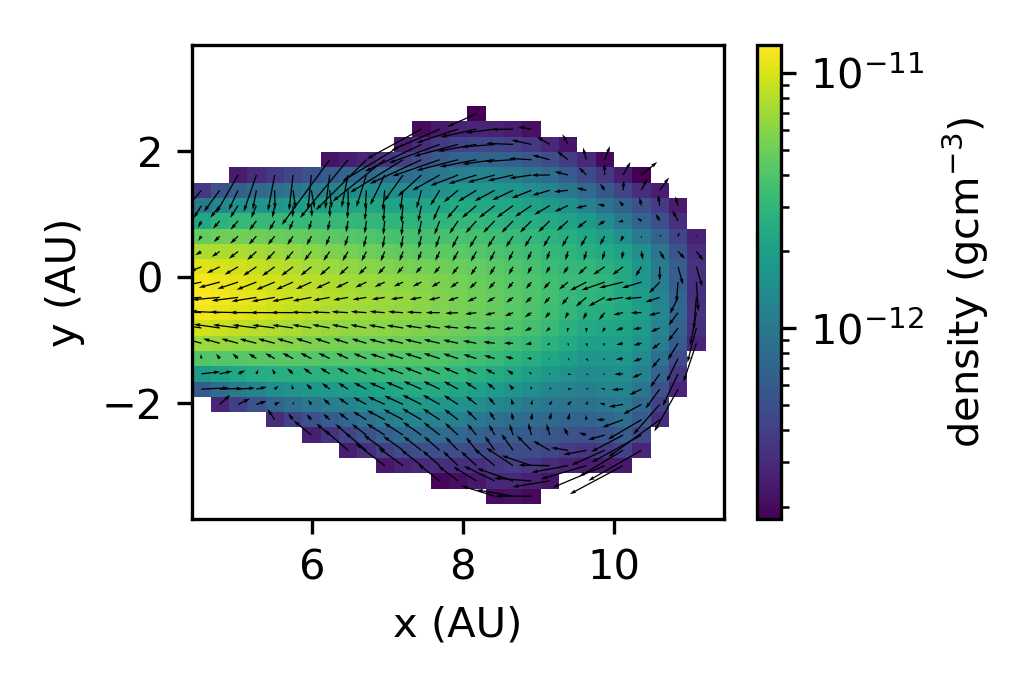

In [51]:
fig, (map_plot1) = plt.subplots(figsize=(3.4,2.3))
#ecc_plot.set_figheight(10)
#map_plot.set_aspect(1)
cm_to_au = 6.6845871226706E-14
cube_au=cube*cm_to_au

sink_pos=np.array((0.0,0.0,0.0))
sink_pos.reshape(1,3)
cut_Dens=disctools.disc_cuts.make_cut_array(density,cut_mom_in,angularMom)
cut_density=disctools.disc_cuts.make_cut_array(density,cut_mom_in,angularMom)
cut_velocity=disctools.disc_cuts.make_cut_array(velocity,cut_mom_in,angularMom)
cut_cube=disctools.disc_cuts.make_cut_array(cube,cut_mom_in,angularMom)


velocity_cut=disctools.disc_cuts.make_cut_array(velocity,cut_mom_in,angularMom)
clip=158
x0=peak[0]+20
yclip=190

c = map_plot1.pcolormesh(cube_au[x0:-clip,peak[1],yclip:-yclip,0],cube_au[x0:-clip,peak[1],yclip:-yclip,2], cut_Dens[x0:-clip,peak[1],yclip:-yclip],norm=colors.LogNorm(), cmap='viridis')
d = map_plot1.quiver(cube_au[x0:-clip,peak[1],yclip:-yclip,0],cube_au[x0:-clip,peak[1],yclip:-yclip,2], velocity_cut[x0:-clip,peak[1],yclip:-yclip,0],velocity_cut[x0:-clip,peak[1],yclip:-yclip,2],scale=1.0e6)
cbar=fig.colorbar(c, ax=map_plot1).set_label("density (gcm$^{-3}$)")
#sink_position_point=map_plot2.scatter([0.0],[0.0],color="black",s=8.0)
#cont = map_plot1.contour(cube_au[5:-5,80,5:-5,0], cube_au[5:-5,80,5:-5,2], np.linalg.norm(angularMom[5:-5,80,5:-5,:],axis=-1)/np.max(np.linalg.norm(angularMom[:,:,:,:])), [0.00005],cmap="magma")

map_plot1.set_xlabel("x (AU)")
map_plot1.set_ylabel("y (AU)")


plt.tight_layout()

<IPython.core.display.Javascript object>


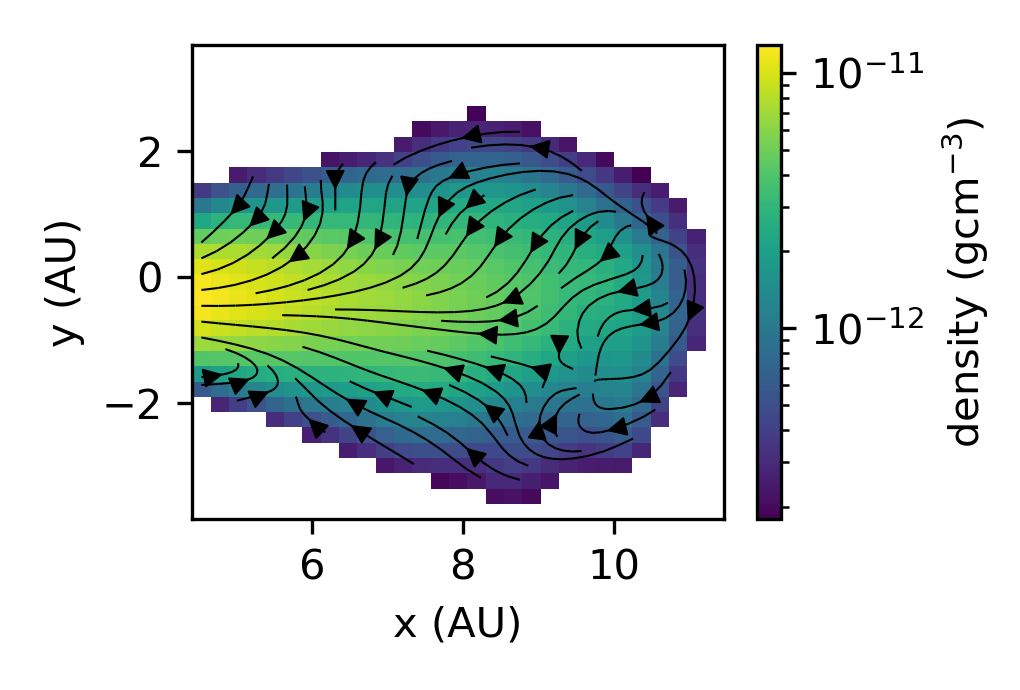

In [72]:
fig, (map_plot1) = plt.subplots(figsize=(3.4,2.3))
#ecc_plot.set_figheight(10)
#map_plot.set_aspect(1)
cm_to_au = 6.6845871226706E-14
cube_au=cube*cm_to_au

sink_pos=np.array((0.0,0.0,0.0))
sink_pos.reshape(1,3)
cut_Dens=disctools.disc_cuts.make_cut_array(density,cut_mom_in,angularMom)
cut_density=disctools.disc_cuts.make_cut_array(density,cut_mom_in,angularMom)
cut_velocity=disctools.disc_cuts.make_cut_array(velocity,cut_mom_in,angularMom)
cut_cube=disctools.disc_cuts.make_cut_array(cube,cut_mom_in,angularMom)


velocity_cut=disctools.disc_cuts.make_cut_array(velocity,cut_mom_in,angularMom)
clip=158
x0=peak[0]+20
yclip=190

c = map_plot1.pcolormesh(cube_au[x0:-clip,peak[1],yclip:-yclip,0],cube_au[x0:-clip,peak[1],yclip:-yclip,2], cut_Dens[x0:-clip,peak[1],yclip:-yclip],norm=colors.LogNorm(), cmap='viridis')
d = map_plot1.streamplot(np.transpose(cube_au[x0:-clip,peak[1],yclip:-yclip,0]),np.transpose(cube_au[x0:-clip,peak[1],yclip:-yclip,2]), u=np.transpose(velocity_cut[x0:-clip,peak[1],yclip:-yclip,0]),v=np.transpose(velocity_cut[x0:-clip,peak[1],yclip:-yclip,2]),linewidth=0.5,color='black')
cbar=fig.colorbar(c, ax=map_plot1).set_label("density (gcm$^{-3}$)")


map_plot1.set_xlabel("x (AU)")
map_plot1.set_ylabel("y (AU)")


plt.tight_layout()

<IPython.core.display.Javascript object>


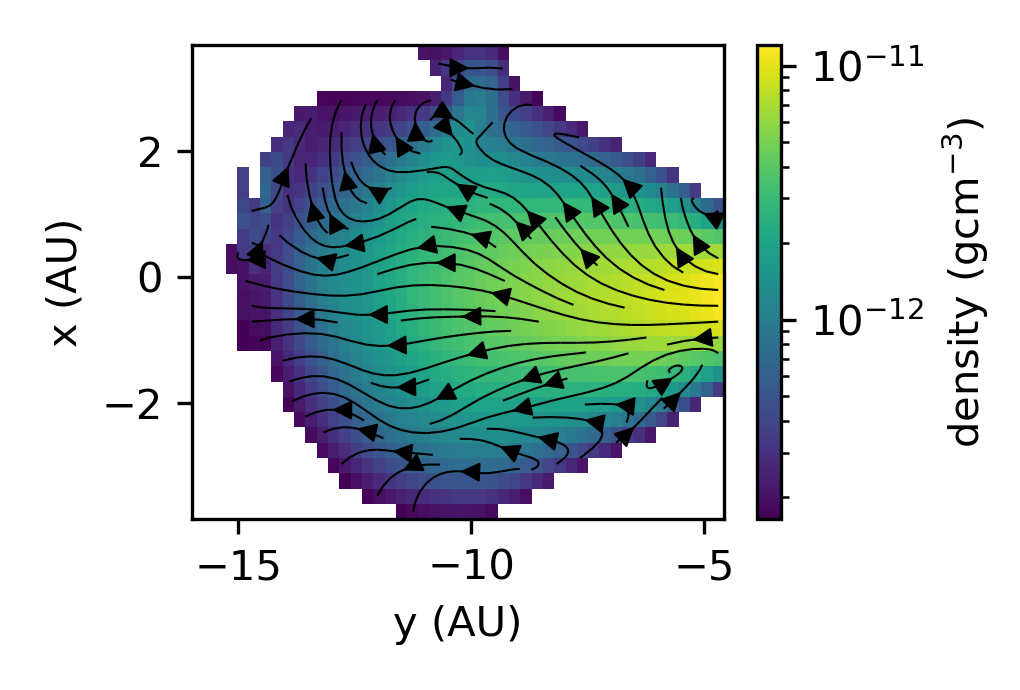

In [68]:
fig, (map_plot1) = plt.subplots(figsize=(3.4,2.3))
#ecc_plot.set_figheight(10)
#map_plot.set_aspect(1)
cm_to_au = 6.6845871226706E-14
cube_au=cube*cm_to_au

sink_pos=np.array((0.0,0.0,0.0))
sink_pos.reshape(1,3)
cut_Dens=disctools.disc_cuts.make_cut_array(density,cut_mom_in,angularMom)
cut_density=disctools.disc_cuts.make_cut_array(density,cut_mom_in,angularMom)
cut_velocity=disctools.disc_cuts.make_cut_array(velocity,cut_mom_in,angularMom)
cut_cube=disctools.disc_cuts.make_cut_array(cube,cut_mom_in,angularMom)


velocity_cut=disctools.disc_cuts.make_cut_array(velocity,cut_mom_in,angularMom)
clip=140
x0=peak[0]+20
yclip=190

c = map_plot1.pcolormesh(cube_au[clip:-x0,peak[1],yclip:-yclip,0],cube_au[clip:-x0,peak[1],yclip:-yclip,2], cut_Dens[clip:-x0,peak[1],yclip:-yclip],norm=colors.LogNorm(), cmap='viridis')
d = map_plot1.streamplot(np.transpose(cube_au[clip:-x0,peak[1],yclip:-yclip,0]),np.transpose(cube_au[clip:-x0,peak[1],yclip:-yclip,2]), u=np.transpose(velocity_cut[clip:-x0,peak[1],yclip:-yclip,0]),v=np.transpose(velocity_cut[clip:-x0,peak[1],yclip:-yclip,2]),linewidth=0.5,color='black')
cbar=fig.colorbar(c, ax=map_plot1).set_label("density (gcm$^{-3}$)")


map_plot1.set_xlabel("y (AU)")
map_plot1.set_ylabel("x (AU)")


plt.tight_layout()

<IPython.core.display.Javascript object>


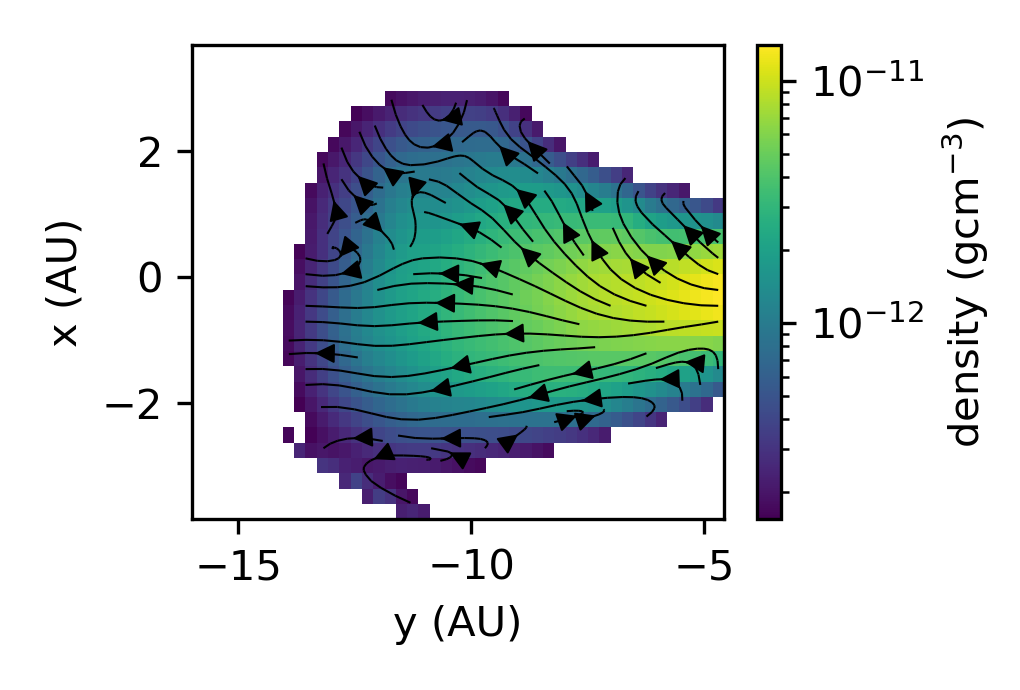

In [69]:
fig, (map_plot1) = plt.subplots(figsize=(3.4,2.3))
#ecc_plot.set_figheight(10)
#map_plot.set_aspect(1)
cm_to_au = 6.6845871226706E-14
cube_au=cube*cm_to_au

sink_pos=np.array((0.0,0.0,0.0))
sink_pos.reshape(1,3)
cut_Dens=disctools.disc_cuts.make_cut_array(density,cut_mom_in,angularMom)
cut_density=disctools.disc_cuts.make_cut_array(density,cut_mom_in,angularMom)
cut_velocity=disctools.disc_cuts.make_cut_array(velocity,cut_mom_in,angularMom)
cut_cube=disctools.disc_cuts.make_cut_array(cube,cut_mom_in,angularMom)


velocity_cut=disctools.disc_cuts.make_cut_array(velocity,cut_mom_in,angularMom)
clip=140
x0=peak[0]+20
yclip=190

c = map_plot1.pcolormesh(cube_au[peak[0],clip:-x0,yclip:-yclip,1],cube_au[peak[0],clip:-x0,yclip:-yclip,2], cut_Dens[peak[0],clip:-x0,yclip:-yclip],norm=colors.LogNorm(), cmap='viridis')
d = map_plot1.streamplot(np.transpose(cube_au[clip:-x0,peak[1],yclip:-yclip,0]),np.transpose(cube_au[peak[0],clip:-x0,yclip:-yclip,2]), u=np.transpose(velocity_cut[peak[0],clip:-x0,yclip:-yclip,1]),v=np.transpose(velocity_cut[clip:-x0,peak[1],yclip:-yclip,2]),linewidth=0.5,color='black')
cbar=fig.colorbar(c, ax=map_plot1).set_label("density (gcm$^{-3}$)")


map_plot1.set_xlabel("y (AU)")
map_plot1.set_ylabel("x (AU)")


plt.tight_layout()